## Exploring the relationship between performance metrics and cost saving potential
This notebook follows the research paper registration by S. Herbold: https://arxiv.org/abs/2104.00566

## _Content_
#### Imports, Settings & Utils
### 1 Descriptive Statistics and Data Visualization
- dataset completeness check
- descriptive statistics
- distribution of cost saving bounds difference ('diff') (+ log-distribution)
- distribution of dependent variable: cost saving potential
- distribution of independent and confounding variables (+ log-distribution)
- influence of preprocessing
- overall correlation matrix
- correlation groups
- scatter plots between independent and confounding variables and lg(diff)
- sensitivity analysis
    
### 2 Evaluation Models
- feature scaling
- data splitting

#### 2.1 logit
- regularization parameter optimization
- run logit model
- plot coefficients

#### 2.2 decision tree
- run decision tree model
- tree visualization
- feature importance

#### 2.3 random forest
- hyperparameter tuning with differential evolution
- run random forest model
- average feature importance
- sensitivity analysis random forest models

### 3 Generalization
- Descriptive Statistics and Data Visualization on Generalization Data
- Test Models on Generalization Data

### 4 Theory Building
- Theory based on Bootstrap Experiment
- Apply Theory on Generalization Data

### Imports

In [1]:
import sys
!{sys.executable} -m pip install graphviz==0.18 matplotlib==3.3.4 numpy==1.20.2 pandas==1.2.4 seaborn==0.11.1 scipy==1.6.2 scikit-learn==0.24.2 statsmodels==0.12.2

In [2]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import time

from scipy.optimize import differential_evolution
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import logit_optimizer

### Settings

In [3]:
plt.rcParams.update({'font.sans-serif': 'Palatino Linotype'})
plt.rcParams.update({'font.size': 14})
heatmap_fontsize = 11

pd.set_option('display.max_columns', 40)

CORRELATION_THRESHOLD = 0.8
SPLIT_TEST_RATIO = 0.3
FIRST_NUM_FEATURE_IDX = 2
RANDOM_STATE = 42
RERUN_LOGIT_OPTIMIZER = False

DATA_PATH = "data"
CSV_FILENAME_BOOTSTRAP = "metrics_vs_costsaving_bootstrap_experiment.csv"
CSV_FILENAME_GENERALIZATION = "metrics_vs_costsaving_realistic_settings.csv"
CSV_FILENAME_TRAINING_DATA = "train_data.csv"
CSV_FILENAME_LOGIT_OPTIM = "logit_optim_grid_search.csv"

PLOT_FORMAT = ".pdf"
FIGURE_PATH = "plots"
LOGIT_OPTIM_DIR = os.path.join(FIGURE_PATH, "logit_optim")
LOGIT_COEF_DIR = os.path.join(FIGURE_PATH, "logit_coef")
CONFUSION_MAT_DIR = os.path.join(FIGURE_PATH, "cm")
CORRELATION_DIR = os.path.join(FIGURE_PATH, "corr")
GENERALIZATION_DIR = os.path.join(FIGURE_PATH, "generalization")
if not os.path.exists(FIGURE_PATH):
    os.makedirs(FIGURE_PATH)
if not os.path.exists(LOGIT_OPTIM_DIR):
    os.makedirs(LOGIT_OPTIM_DIR)
if not os.path.exists(LOGIT_COEF_DIR):
    os.makedirs(LOGIT_COEF_DIR)
if not os.path.exists(CONFUSION_MAT_DIR):
    os.makedirs(CONFUSION_MAT_DIR)
if not os.path.exists(CORRELATION_DIR):
    os.makedirs(CORRELATION_DIR)
if not os.path.exists(GENERALIZATION_DIR):
    os.makedirs(GENERALIZATION_DIR)

### Utilities

In [4]:
def dataset_overview(df):
    """Gives an overview of the dataframe to check for its completeness."""
    num_releases = df["release"].nunique()
    instances_per_release = df["num_test"].groupby(df["release"]).count().unique().tolist()
    print(f"Number of releases: {num_releases}")
    print(f"Instances per release: {instances_per_release}")
    print(f"Total number of instances: {df.shape[0]}\n")
    print(f"Overall number of NaN:               {df.isna().sum().sum()}")
    print(f"Overall number of NaN (no 'diff'):   {df.drop('diff', axis=1).isna().sum().sum()}")
    print(f"Number of rows with NaN:             {df[df.isna().any(axis=1)].shape[0]}")
    print(f"Number of rows with NaN (no 'diff'): {df[df.drop('diff', axis=1).isna().any(axis=1)].shape[0]}")
    print("\nNaNs per variable:")
    print(df.isna().sum().loc[df.isna().sum()>0] )
    print("\ninfs per variable:")
    inf_array = np.isinf(df.drop(["configuration","release","potential"], axis=1)).sum()
    print(inf_array[inf_array>0])

def no_bugs_instances_costs(df):
    """Analyze the cost for instances without defects and returns the dataframe without those instances.

    These instances need to be analyzed separately and filtered from the overall data, as multiple metrics become invalid.
    """
    no_bugs_test = df.loc[df['bias_test']==0]
    no_bugs_train = df.loc[df['bias_train_processed']==0]
    print(f"Number of instances without any defects in the test data: {no_bugs_test.shape[0]}")
    print(f"Costs through QA efforts for false positives in those instances:")
    print(f"min: {no_bugs_test['cost'].min():.0f}, max: {no_bugs_test['cost'].max():.0f}, median: {no_bugs_test['cost'].median():.2f}, sum: {no_bugs_test['cost'].sum():.0f}\n")
    print(f"Number of instances without any defects in the processed training data: {no_bugs_train.shape[0]}")
    print(f"Costs through QA efforts for false positives in those instances:")
    print(f"min: {no_bugs_train['cost'].min():.0f}, max: {no_bugs_train['cost'].max():.0f}, median: {no_bugs_train['cost'].median():.2f}, sum: {no_bugs_train['cost'].sum():.0f}")
    return df.loc[(df['bias_test']!=0) & (df['bias_train_processed']!=0)]

def dataset_descriptive_stats(df):
    """Returns a dataframe containing descriptive statistics for every feature."""
    desc_stats = pd.DataFrame(columns=df.columns)
    desc_stats = desc_stats.append((df.mean(axis=0).rename("mean")))
    desc_stats = desc_stats.append(df.std(axis=0).rename("std"))
    desc_stats = desc_stats.append(df.min(axis=0, numeric_only=True).rename("min"))
    desc_stats = desc_stats.append(df.max(axis=0, numeric_only=True).rename("max"))
    desc_stats = desc_stats.append(df.median(axis=0).rename("median"))
    desc_stats = desc_stats.append(df.quantile(0.25).rename("25q"))
    desc_stats = desc_stats.append(df.quantile(0.75).rename("75q"))
    return desc_stats

def detect_correlation_groups(overall_spearman_corr_map, df_numeric, save_dir, threshold):
    """Divides the features into groups where every member of the group has a spearman rank correlation higher than a threshold value
    with at least one other member of the group."""
    
    class CorrGroup:
        """Keeps elements which belong to the same correlation group."""

        def __init__(self, elem_list):
            self.elements = elem_list

        def check_and_add(self, a, b):
            """Checks if at least one of the two elements is already part of the correlation group 
            and adds the missing element if only one is included.

            Returns:
                True if elements are part of the group and False otherwise.
            """
            contains_a = False
            contains_b = False
            for element in self.elements:
                if element == a:
                    contains_a = True
                if element == b:
                    contains_b = True
            if contains_a == True and contains_b == True:
                return True
            elif contains_a == True and contains_b == False:
                self.elements.append(b)
                return True
            elif contains_a == False and contains_b == True:
                self.elements.append(a)
                return True
            else:
                return False

    corr_matrix = overall_spearman_corr_map
    temp_groups = []
    for i, corr_row in enumerate(corr_matrix):
        for j, c in enumerate(corr_row):
            if i != j:
                if abs(c) > threshold:
                    group_found = False
                    for group in temp_groups:
                        group_found = group.check_and_add(a=i,b=j)
                    if not group_found:
                        temp_groups.append(CorrGroup([i,j]))
    corr_groups = []                    
    for group in temp_groups:
        group_handled = False
        for cg in corr_groups:
            if any(x in group.elements for x in cg):
                cg = np.unique(cg+group.elements)
                group_handled = True
        if not group_handled:
            corr_groups.append(group.elements)
    counter = 0       
    for group in corr_groups:
        df_group = df_numeric.iloc[:,group]
        spearman_corr_map = spearmanr(a=df_group).correlation
        if df_group.shape[1] == 2:
            spearman_corr_map = [[1,spearman_corr_map],[spearman_corr_map,1]]
        plt.figure(figsize=(5,5))
        ax = sns.heatmap(spearman_corr_map, square=True, annot=True, xticklabels=df_group.columns, 
                         yticklabels=df_group.columns, cmap="vlag", vmin=-1, vmax=1, annot_kws={"size": heatmap_fontsize})
        plt.savefig(os.path.join(save_dir, f"corr_group_{counter}" + PLOT_FORMAT), bbox_inches='tight')
        plt.title(f"Correlation group {counter}")
        plt.show()
        counter += 1


def bar_plot_wrapper(data, x_labels, data_std=None, set_labels=None, filename=None, title="Logit model coefficients",
                     xlabel="feature", ylabel="coefficients", figsize=(8, 4), rotate_ticks=False):
    """Wrapper around matplotlib's bar function in order to plot coefficient diagrams."""

    length = data.shape[0]
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.8 / data.shape[1]
    x = np.arange(length)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.4)

    for i in range(data.shape[1]):
        if data_std is None and set_labels is None:
            ax.bar(x + (i * width), data[:, i], width)
        elif set_labels is None:
            ax.bar(x + (i * width), data[:, i], width, yerr=data_std[:, i])
        elif data_std is None:
            ax.bar(x + (i * width), data[:, i], width, label=set_labels[i])
        else:
            ax.bar(x + (i * width), data[:, i], width, label=set_labels[i], yerr=data_std[:, i])

    ax.set_xticks(x + width * (data.shape[1] - 1) / 2)
    ax.set_xticklabels(x_labels)
    if rotate_ticks:
        plt.xticks(rotation=90)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if set_labels is not None:
        ax.legend()
    plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.2)
    for j in range(1, data.shape[0]):
        plt.axvline(x=x[j] + width * (data.shape[1] - 1) / 2 - 0.5, color='black', linestyle='-', linewidth=0.4)
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename, bbox_inches="tight")
    if title is not None:
        ax.set_title(title)
    fig.tight_layout()
    plt.show()

    
def confusion_matrix_eval(cm, class_labels):
    """Evaluates a confusion matrix and returns a dataframe with the statistics."""
    
    cm_df = pd.DataFrame(columns=class_labels)
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        temp[i] = row[i]/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="correctly_predicted"))
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i+1 < cm.shape[0]:
            temp[i] = row[i+1]/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="moderate_overprediction"))
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i+1 < cm.shape[0]:
            temp[i] = row[i+1:].sum()/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="overall_overprediction"))
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i > 0:
            temp[i] = row[i-1]/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="moderate_underprediction")) 
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i > 0:
            temp[i] = row[:i].sum()/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="overall_underprediction"))
    return cm_df


# setup for metrics dataframe
metrics_names = ['name', 'training t.', 'prediction t.', 'recall', 'precision', 'accuracy', 'F1 measure', 'MCC']
metrics_df = pd.DataFrame(columns=metrics_names)

def performance_eval(y_model, ytest, class_labels, t=None, name="", df=metrics_df, save_dir=CONFUSION_MAT_DIR):
    """Calculates different metrics to evaluate a model's performance and plots the confusion matrix."""
    
    mcc = metrics.matthews_corrcoef(ytest, y_model)
    recall = metrics.recall_score(ytest, y_model, average='macro')
    precision = metrics.precision_score(ytest, y_model, average='macro')
    accuracy = metrics.accuracy_score(ytest, y_model)
    f1 = metrics.f1_score(ytest, y_model, average='macro')
    if t is None:
        t = [0, 0, 0]
    results = pd.Series([name, t[1]-t[0], t[2]-t[1], recall, precision, accuracy, f1, mcc], index = df.columns)
    print(results)
    cm = metrics.confusion_matrix(y_true=ytest, y_pred=y_model, labels=class_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = cm_norm.transpose()
    cm_norm = np.round(cm_norm, 3)
    ax = sns.heatmap(cm_norm, square=True, annot=True, xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
    plt.yticks(rotation=0)
    plt.xlabel('true value')
    plt.ylabel('predicted value')
    plt.savefig(os.path.join(save_dir, f"{name}_CM" + PLOT_FORMAT), bbox_inches="tight")
    plt.show()
    cm_df = confusion_matrix_eval(cm, class_labels)
    print(cm_df)
    return results


def run_model(model, model_name, Xtrain, ytrain, Xtest, ytest, metrics, class_labels):
    """Runs and evaluates a sklearn machine learning model."""

    t0 = time.time()
    model.fit(X=Xtrain, y=ytrain)
    t1 = time.time()
    y_pred = model.predict(Xtest)
    t2 = time.time()
    metrics = metrics.append(performance_eval(y_model=y_pred, ytest=ytest, class_labels=class_labels, t=[t0,t1,t2], name=model_name), ignore_index=True)
    return model, metrics


def resort_coef(model_coef, model_classes, ordered_classes):
    """Returns the coefficient matrix resorted by the desired order of classes."""

    if len(model_classes) != len(ordered_classes):
        raise ValueError("The classes by the model and the ordered list of classes must have the same length.") 
    index_list = np.full(len(model_classes), -1)
    for i, ordered_c in enumerate(ordered_classes):
        for j, model_c in enumerate(model_classes):
            if ordered_c == model_c:
                index_list[i]=j
    _, unique_count = np.unique(index_list, return_counts=True)
    if unique_count.max() > 1 or -1 in index_list:
        raise ValueError("The two lists of classes do not consist of the same elements.")
    sorted_coef = model_coef[index_list]   
    return sorted_coef

### Read the data
The dataset is created by a bootstrap experiment in CrossPare and formatted by the notebook read_sql.ipynb



In [5]:
bt_df = pd.read_csv(os.path.join(DATA_PATH, CSV_FILENAME_BOOTSTRAP), index_col=0)
print(f"Shape of the dataset: {bt_df.shape}")

Shape of the dataset: (53000, 34)


# 1: Descriptive Statistics and Data Visualization
### Dataset completeness check
#### expected values:
- number of releases = 265 
- instances per release = 200 (2*100)
- total number of instances = 53000 (2*26500)

In [6]:
dataset_overview(bt_df)

Number of releases: 265
Instances per release: [200]
Total number of instances: 53000

Overall number of NaN:               12075
Overall number of NaN (no 'diff'):   0
Number of rows with NaN:             12075
Number of rows with NaN (no 'diff'): 0

NaNs per variable:
diff    12075
dtype: int64

infs per variable:
diff    12104
dtype: int64


### Evaluate and remove instances without bugs in test data or processed training data

In [7]:
bt_df = no_bugs_instances_costs(bt_df)

Number of instances without any defects in the test data: 0
Costs through QA efforts for false positives in those instances:
min: nan, max: nan, median: nan, sum: 0

Number of instances without any defects in the processed training data: 0
Costs through QA efforts for false positives in those instances:
min: nan, max: nan, median: nan, sum: 0


In [8]:
dataset_overview(bt_df)

Number of releases: 265
Instances per release: [200]
Total number of instances: 53000

Overall number of NaN:               12075
Overall number of NaN (no 'diff'):   0
Number of rows with NaN:             12075
Number of rows with NaN (no 'diff'): 0

NaNs per variable:
diff    12075
dtype: int64

infs per variable:
diff    12104
dtype: int64


### Descriptive statistics

In [9]:
dataset_descriptive_stats(bt_df)

C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


configuration  release    recall  precision       fpr  f_measure  \
mean              NaN      NaN  0.171032   0.521851  0.022190   0.193396   
std               NaN      NaN  0.216350   0.381978  0.032353   0.217555   
min               NaN      NaN  0.000000   0.000000  0.000000   0.000000   
max               NaN      NaN  1.000000   1.000000  0.404762   1.000000   
median            NaN      NaN  0.090909   0.500000  0.010989   0.142857   
25q               NaN      NaN  0.000000   0.200000  0.000000   0.000000   
75q               NaN      NaN  0.285714   1.000000  0.028571   0.333333   

        g_measure   balance  accuracy     error  error_type1  error_type2  \
mean     0.239728  0.412477  0.928764  0.071236     0.326751     0.056615   
std      0.266212  0.150277  0.048461  0.048461     0.520102     0.041323   
min      0.000000  0.270018  0.600000  0.000000     0.000000     0.000000   
max      1.000000  1.000000  1.000000  0.400000    12.000000     0.476190   
median   0.166604  0.357168  0.940594  0.059406     0.190476     0.047120   
25q      0.000000  0.292893  0.905263  0.036232     0.000000     0.027778   
75q      0.441605  0.494521  0.963768  0.094737     0.428571     0.074074   

             mcc  consistency       auc  auc_alberg   auc_roi    necm10  \
mean    0.182078     0.114417  0.790624    0.013403  0.575275  0.532306   
std     0.219869     0.222572  0.115931    0.018125  0.139337  0.346677   
min    -0.173902    -0.466667  0.055556    0.000000  0.012178  0.000000   
max     1.000000     1.000000  1.000000    0.185233  1.000000  3.181818   
median  0.129023     0.015152  0.807238    0.006870  0.572759  0.461538   
25q     0.000000    -0.038462  0.725961    0.001053  0.493759  0.282759   
75q     0.342020     0.225238  0.870939    0.018157  0.653487  0.698630   

          necm25          cost     nofb20      nofc80  bias_train  \
mean    1.300757   3579.802868   2.763623   76.475075    0.065685   
std     0.855657   6453.838682   3.841023   72.797629    0.044151   
min     0.000000      0.000000   0.000000    1.000000    0.002347   
max     7.954545  56593.000000  35.000000  634.000000    0.333333   
median  1.126795    974.000000   2.000000   54.000000    0.054417   
25q     0.684685     82.000000   0.000000   26.000000    0.033482   
75q     1.709858   3037.000000   4.000000  101.000000    0.088435   

        bias_train_processed  bias_test  ratio_bias  ratio_bias_processed  \
mean                0.150173   0.065939    1.142955              0.726042   
std                 0.125453   0.045859    0.724122              0.686986   
min                 0.002347   0.002481    0.066808              0.023711   
max                 0.692641   0.382353   14.300000             14.300000   
median              0.108252   0.054348    1.004008              0.496633   
25q                 0.051220   0.032609    0.731631              0.258764   
75q                 0.218121   0.088608    1.347826              1.017794   

        prop1_defect  prop1_clean    num_train  num_train_processed  \
mean      152.347081    15.084337   506.490566           560.944302   
std       199.296946    12.954148   343.118544           383.734655   
min         5.600000     1.819095   100.000000           100.000000   
max      3756.000000    92.700000  1708.000000          1940.000000   
median     83.400000    10.806122   425.000000           462.000000   
25q        47.166667     6.866667   236.000000           250.000000   
75q       173.000000    16.954017   708.000000           766.000000   

          num_test         diff  potential  
mean    186.097717          NaN        NaN  
std     126.318760          NaN        NaN  
min      28.000000         -inf        NaN  
max     667.000000          inf        NaN  
median  153.000000   990.309524        NaN  
25q      86.000000          NaN        NaN  
75q     262.000000  2224.044118        NaN

### Distribution of cost saving bounds difference


Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns 24179 instances.
Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns 30 instances.


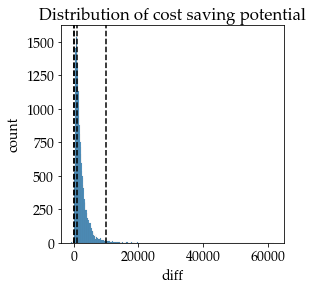

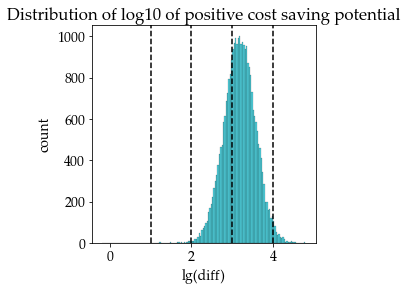

POSITIVES mean: 3.182, std: 0.385


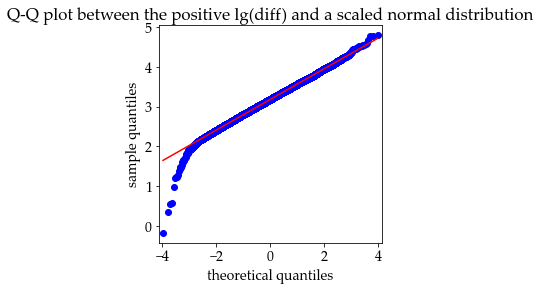

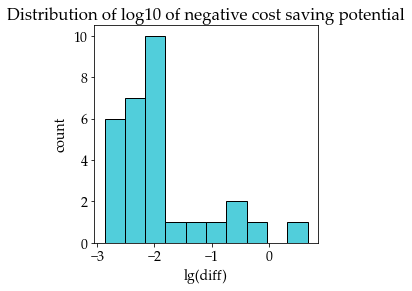

NEGATIVES mean: -1.903, std: 0.837


In [10]:
figsize_diff_dist = (4,4)
regular_df = bt_df.loc[~(bt_df['diff'].isnull()) & ~(np.isinf(bt_df["diff"]))]
regular_diff = bt_df.loc[~(bt_df['diff'].isnull()) & ~(np.isinf(bt_df["diff"])), 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

print(f"Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns {bt_df.shape[0]-regular_diff.shape[0]} instances.")
print(f"Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns {neg_diff.shape[0]} instances.")


plt.figure(figsize=figsize_diff_dist)
sns.histplot(data=regular_diff)
plt.ylabel("count")
plt.axvline(10, color="black", linestyle="--")
plt.axvline(100, color="black", linestyle="--")
plt.axvline(1000, color="black", linestyle="--")
plt.axvline(10000, color="black", linestyle="--")
plt.title(label="")
plt.savefig(os.path.join(FIGURE_PATH, "dist_diff" + PLOT_FORMAT), bbox_inches='tight')

plt.title("Distribution of cost saving potential")
plt.show()


plt.figure(figsize=figsize_diff_dist)
sns.histplot(data=log_pos_diff, color="tab:cyan")
plt.ylabel("count")
plt.axvline(1, color="black", linestyle="--")
plt.axvline(2, color="black", linestyle="--")
plt.axvline(3, color="black", linestyle="--")
plt.axvline(4, color="black", linestyle="--")
plt.xlabel("lg(diff)")
plt.title(label="")
plt.savefig(os.path.join(FIGURE_PATH, "dist_pos_log_diff" + PLOT_FORMAT), bbox_inches='tight')

plt.title("Distribution of log10 of positive cost saving potential")
plt.show()
print(f"POSITIVES mean: {log_pos_diff.mean():0.3f}, std: {log_pos_diff.std():0.3f}")


fig = plt.figure(figsize=figsize_diff_dist)
ax = fig.add_subplot(111)
sm.qqplot(log_pos_diff, line='s', ax=ax) # line='45'
plt.title(label="")
plt.ylabel('sample quantiles')
plt.xlabel('theoretical quantiles')
plt.savefig(os.path.join(FIGURE_PATH, "qqplot_pos_log_diff" + PLOT_FORMAT), bbox_inches='tight')

plt.title("Q-Q plot between the positive lg(diff) and a scaled normal distribution")
plt.show()


plt.figure(figsize=figsize_diff_dist)
sns.histplot(data=log_neg_diff, color="tab:cyan")
plt.ylabel("count")
plt.xlabel("lg(diff)")

plt.savefig(os.path.join(FIGURE_PATH, "dist_neg_log_diff" + PLOT_FORMAT), bbox_inches='tight')

plt.title("Distribution of log10 of negative cost saving potential")
plt.show()
print(f"NEGATIVES mean: {log_neg_diff.mean():0.3f}, std: {log_neg_diff.std():0.3f}")

In [11]:
print("regular diff distribution")
print(f"x <= 0:            {(regular_diff<=0).sum()}")
print(f"0 < x <= 10:       {((regular_diff>0) & (regular_diff<=10)).sum()}")
print(f"10 < x <= 100:     {((regular_diff>10) & (regular_diff<=100)).sum()}")
print(f"100 < x <= 1000:   {((regular_diff>100) & (regular_diff<=1000)).sum()}")
print(f"1000 < x <= 10000: {((regular_diff>1000) & (regular_diff<=10000)).sum()}")
print(f"10000 < x:         {(regular_diff>10000).sum()}")
print("regular diff distribution normed")
print(f"x <= 0:            {(regular_diff<=0).sum()/regular_diff.shape[0]}")
print(f"0 < x <= 10:       {((regular_diff>0) & (regular_diff<=10)).sum()/regular_diff.shape[0]}")
print(f"10 < x <= 100:     {((regular_diff>10) & (regular_diff<=100)).sum()/regular_diff.shape[0]}")
print(f"100 < x <= 1000:   {((regular_diff>100) & (regular_diff<=1000)).sum()/regular_diff.shape[0]}")
print(f"1000 < x <= 10000: {((regular_diff>1000) & (regular_diff<=10000)).sum()/regular_diff.shape[0]}")
print(f"10000 < x:         {(regular_diff>10000).sum()/regular_diff.shape[0]}")

regular diff distribution
x <= 0:            30
0 < x <= 10:       5
10 < x <= 100:     58
100 < x <= 1000:   8938
1000 < x <= 10000: 19332
10000 < x:         458
regular diff distribution normed
x <= 0:            0.0010409076714895389
0 < x <= 10:       0.00017348461191492315
10 < x <= 100:     0.0020124214982131087
100 < x <= 1000:   0.3101210922591166
1000 < x <= 10000: 0.6707609035078589
10000 < x:         0.01589119045140696


In [12]:
print("counts")
print(f"regular instances: {regular_diff.shape[0]}")
print(f"+inf instances:    {bt_df.loc[(bt_df['diff'] > 0) & (np.isinf(bt_df['diff'])), 'diff'].shape[0]}")
print(f"-inf instances:    {bt_df.loc[(bt_df['diff'] < 0) & (np.isinf(bt_df['diff'])), 'diff'].shape[0]}")
print(f"NaN instances:     {bt_df.loc[(bt_df['diff'].isnull()), 'diff'].shape[0]}")
print("shares")
print(f"share regular instances: {regular_diff.shape[0]/bt_df.shape[0]}")
print(f"share +inf instances:    {bt_df.loc[(bt_df['diff'] > 0) & (np.isinf(bt_df['diff'])), 'diff'].shape[0]/bt_df.shape[0]}")
print(f"share -inf instances:    {bt_df.loc[(bt_df['diff'] < 0) & (np.isinf(bt_df['diff'])), 'diff'].shape[0]/bt_df.shape[0]}")
print(f"share NaN instances:     {bt_df.loc[(bt_df['diff'].isnull()), 'diff'].shape[0]/bt_df.shape[0]}")

counts
regular instances: 28821
+inf instances:    583
-inf instances:    11521
NaN instances:     12075
shares
share regular instances: 0.5437924528301887
share +inf instances:    0.011
share -inf instances:    0.21737735849056602
share NaN instances:     0.2278301886792453


## Distribution of dependent variable: cost saving potential

To even out the class imbalance, the classes _negligible_ and _small_ are included into _medium_ by the next cell

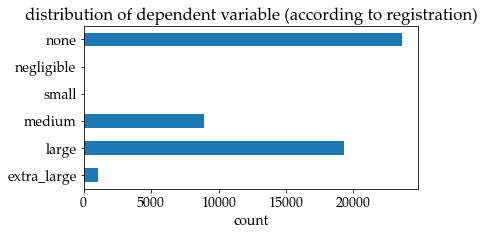

Original potential class distribution:
 none           23626
negligible         5
small             58
medium          8938
large          19332
extra_large     1041
Name: potential, dtype: int64 


Original potential class distribution normed:
 none           0.445774
negligible     0.000094
small          0.001094
medium         0.168642
large          0.364755
extra_large    0.019642
Name: potential, dtype: float64 




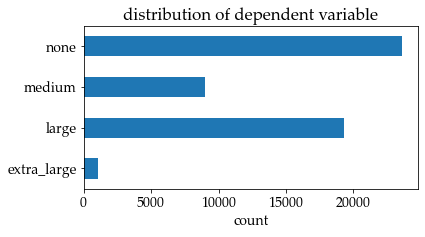

Condensed potential class distribution:
 none           23626
medium          9001
large          19332
extra_large     1041
Name: potential, dtype: int64 


Original potential class distribution normed:
 none           0.445774
medium         0.169830
large          0.364755
extra_large    0.019642
Name: potential, dtype: float64 




In [13]:
original_classes = ['none','negligible','small','medium','large','extra_large']
plt.figure(figsize=(6,3))
bt_df['potential'].value_counts()[original_classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("count")
plt.savefig(os.path.join(FIGURE_PATH, f"dist_dependent_original" + PLOT_FORMAT), bbox_inches='tight')
plt.title("distribution of dependent variable (according to registration)")
plt.show()
print(f"Original potential class distribution:\n",bt_df['potential'].value_counts()[original_classes], "\n\n")
print(f"Original potential class distribution normed:\n",(bt_df['potential'].value_counts()/bt_df.shape[0])[original_classes], "\n\n")

# include 'negligible' and 'small' into 'medium'
bt_df.loc[bt_df['potential'] == 'negligible', 'potential'] = "medium"
bt_df.loc[bt_df['potential'] == 'small', 'potential'] = "medium"

classes = ['none','medium','large','extra_large']
plt.figure(figsize=(6,3))
bt_df['potential'].value_counts()[classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("count")
plt.savefig(os.path.join(FIGURE_PATH, f"dist_dependent_updated" + PLOT_FORMAT), bbox_inches='tight')
plt.title("distribution of dependent variable")
plt.show()
print(f"Condensed potential class distribution:\n",bt_df['potential'].value_counts()[classes], "\n\n")
print(f"Original potential class distribution normed:\n",(bt_df['potential'].value_counts()/bt_df.shape[0])[classes], "\n\n")

### Distribution of independent and confounding variables

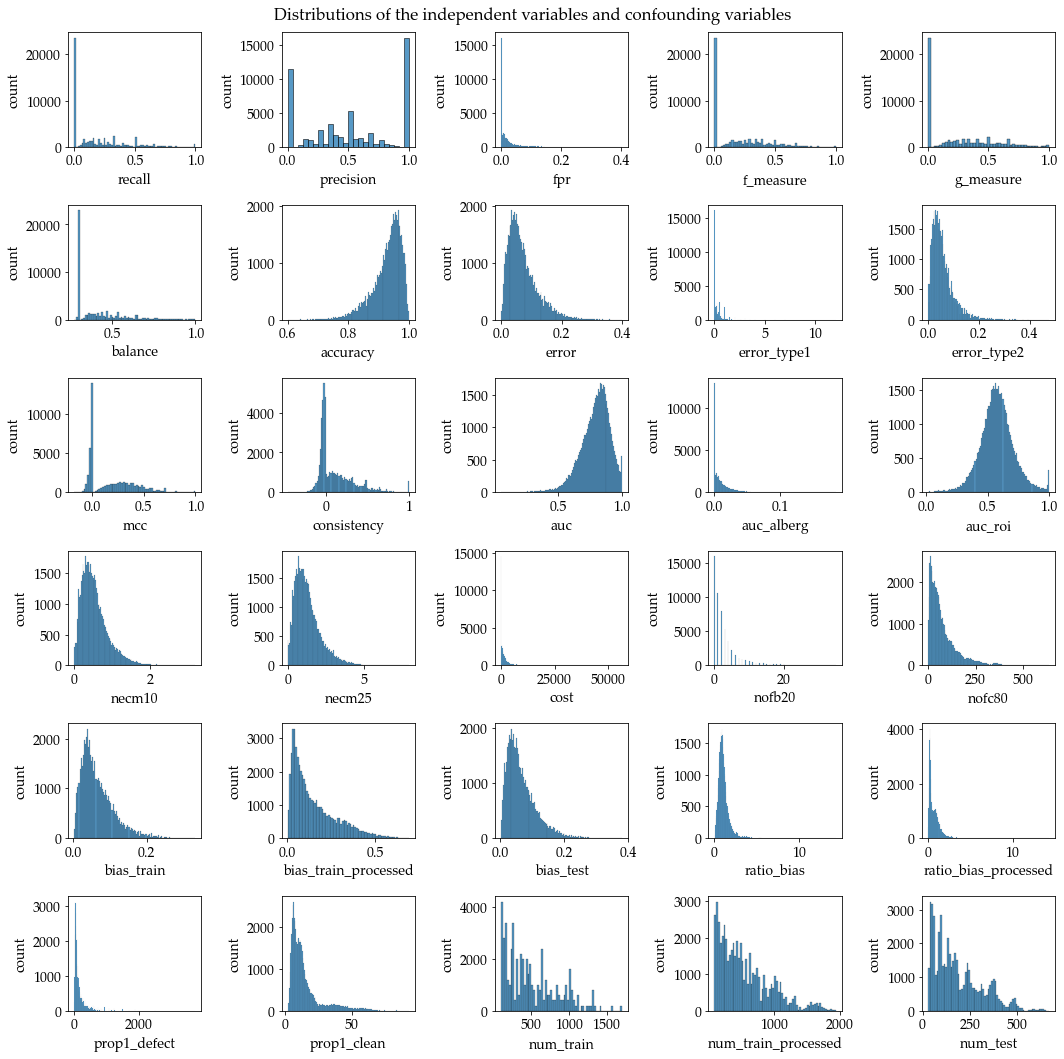

In [14]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))

feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(bt_df, x=bt_df.columns[feature_index], ax=col)
        col.set_ylabel("count")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, "dist_independent_and_confounding" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Distributions of the independent variables and confounding variables")
plt.tight_layout()
plt.show()

#### Log distribution of independent and confounding variables


NOTE: For computational reasons all 0 values in this plot are replaced with 1e-3.


C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


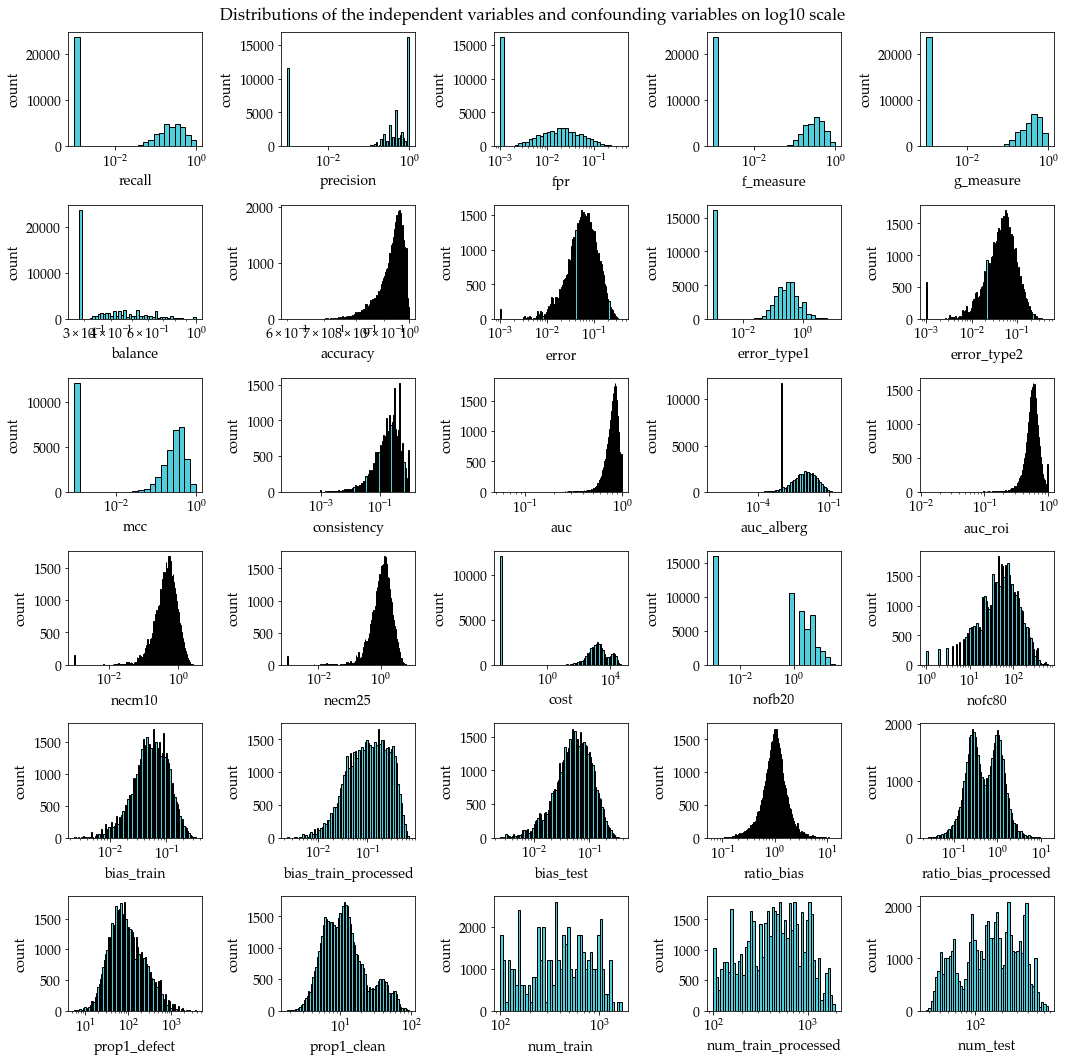

In [15]:
bt_df_4_log = bt_df.copy(deep=True)
bt_df_4_log.replace(to_replace=0, value=0.001, inplace=True)
print("NOTE: For computational reasons all 0 values in this plot are replaced with 1e-3.")

fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(bt_df_4_log, x=bt_df_4_log.columns[feature_index], color="tab:cyan", ax=col, log_scale=True)
        col.set_xlabel(bt_df_4_log.columns[feature_index])
        col.set_ylabel("count")
        feature_index += 1

plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, "dist_log_independent_and_confounding" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Distributions of the independent variables and confounding variables on log10 scale")
plt.tight_layout()
plt.show()

### Influence of preprocessing (SMOTUNED)

median bias from the instances processed with SMOTUNED: 0.216


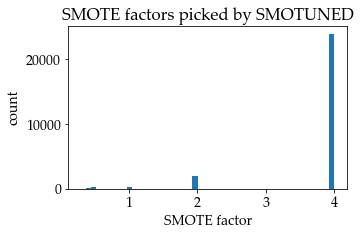

4.0    23992
2.0     1951
1.0      233
0.5      220
0.4       81
0.3       23
Name: smote, dtype: int64

In [16]:
df_s= bt_df.loc[bt_df["configuration"] == "Smotuned"]
print(f"median bias from the instances processed with SMOTUNED: {df_s['bias_train_processed'].median():0.3f}")
df_s = df_s[["bias_train", "bias_train_processed", "num_train", "num_train_processed", "ratio_bias", "ratio_bias_processed"]]
df_s["bugs"] = df_s["bias_train"] * df_s["num_train"]
df_s["bugs_s"] = df_s["bias_train_processed"] * df_s["num_train_processed"]
df_s["smote"] = df_s["bugs_s"] / df_s["bugs"] - 1  # get the smote factor
df_s["smote"]=df_s["smote"].round(decimals=1)

plt.figure(figsize=(5,3))
df_s["smote"].plot.hist(bins=50)
plt.ylabel("count")
plt.xlabel("SMOTE factor")
plt.savefig(os.path.join(FIGURE_PATH, f"smote_factor" + PLOT_FORMAT), bbox_inches='tight')
plt.title("SMOTE factors picked by SMOTUNED")
plt.show()

df_s["smote"].value_counts(sort=True)

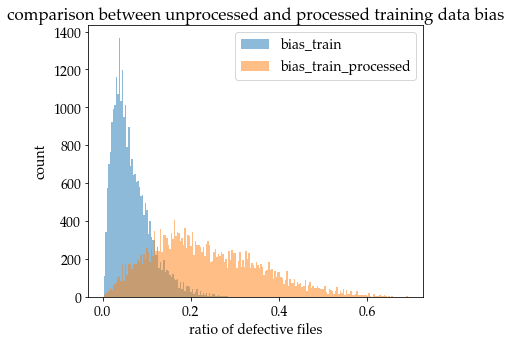

In [17]:
df_s[["bias_train", "bias_train_processed"]].plot(kind="hist", alpha=0.5, bins=200, figsize=(6,5))
plt.xlabel("ratio of defective files")
plt.ylabel("count")
plt.savefig(os.path.join(FIGURE_PATH, f"smote_bias_dist" + PLOT_FORMAT), bbox_inches='tight')
plt.title("comparison between unprocessed and processed training data bias")
plt.show()

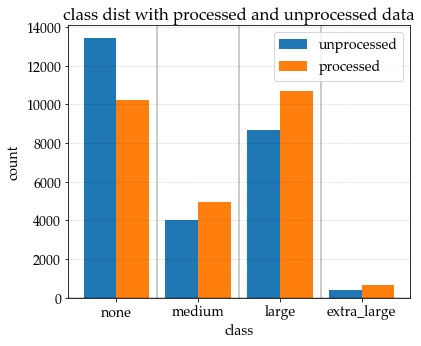

In [18]:
counts_unprocessed = bt_df.loc[~ (bt_df["configuration"]=="Smotuned")]['potential'].value_counts()[classes]
counts_processed = bt_df.loc[bt_df["configuration"]=="Smotuned"]['potential'].value_counts()[classes]
plot_data = np.asarray((counts_unprocessed,counts_processed))

bar_plot_wrapper(plot_data.T, classes, data_std=None, set_labels=["unprocessed","processed"],
                 filename=os.path.join(FIGURE_PATH, "smote_classes_dist" + PLOT_FORMAT), title="class dist with processed and unprocessed data",
                 xlabel="class", ylabel="count", figsize=(6, 5), rotate_ticks=False)

### Overall correlation Matrix
Spearman-rank correlation between all the independent and confounding variables

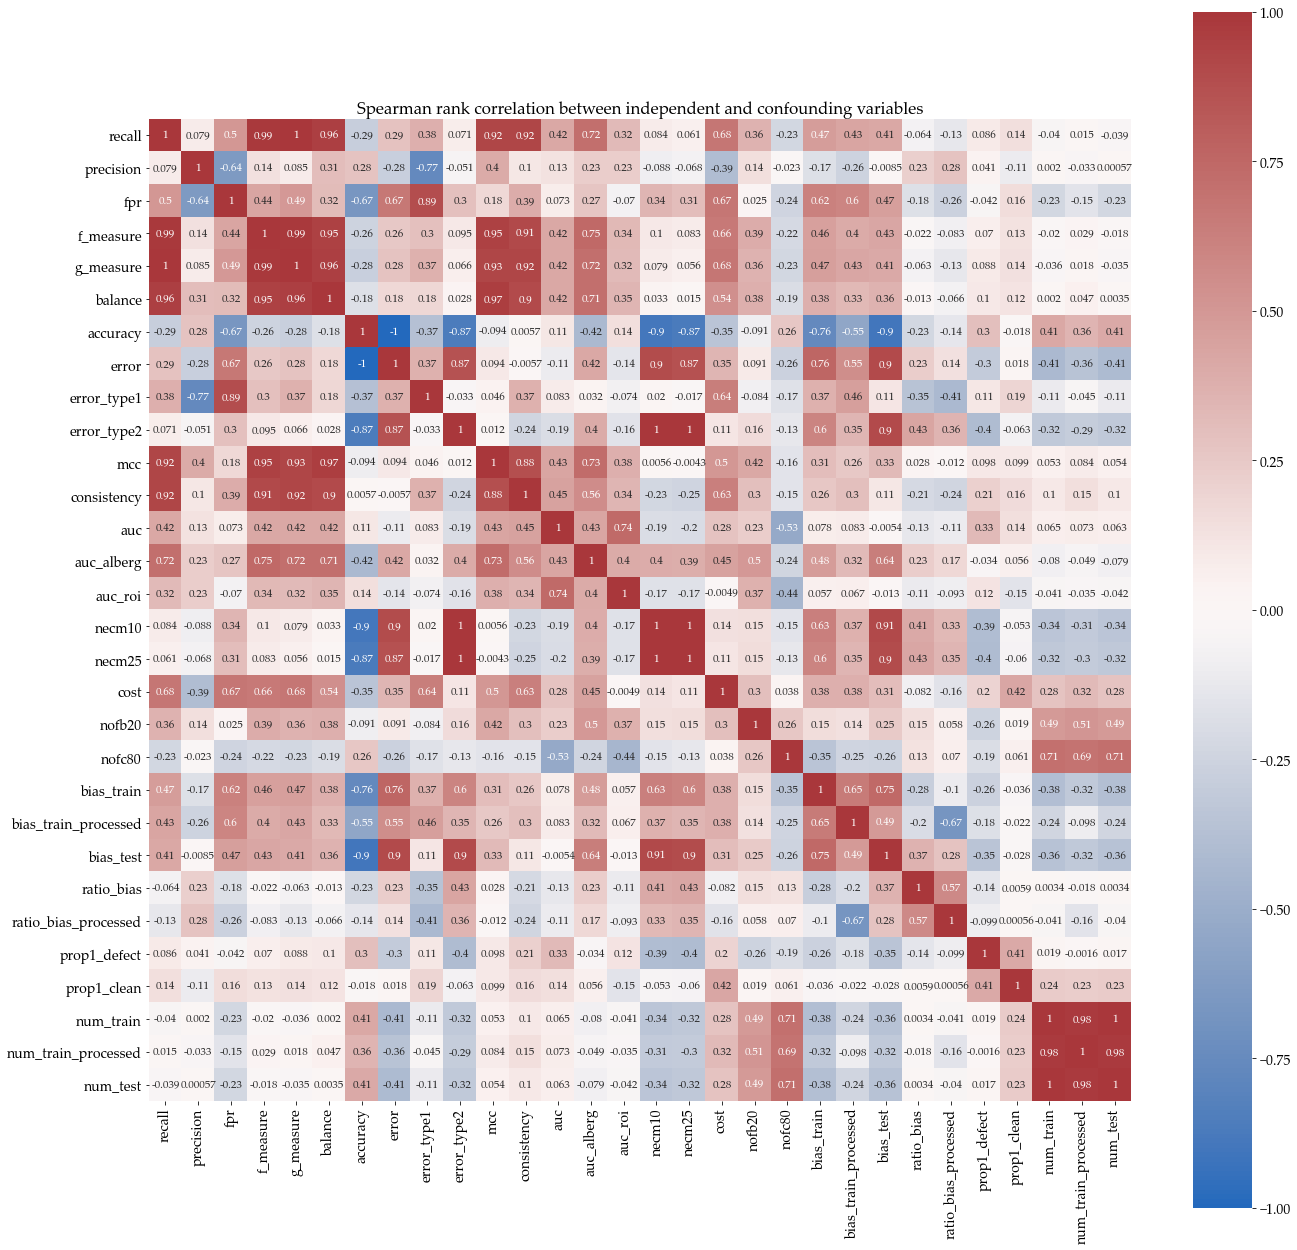

In [19]:
df_numeric = bt_df.iloc[:,FIRST_NUM_FEATURE_IDX:FIRST_NUM_FEATURE_IDX+30]
overall_spearman_corr_map = spearmanr(a=df_numeric).correlation

plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map, square=True, annot=True, xticklabels=df_numeric.columns,
                 yticklabels=df_numeric.columns, cmap="vlag", annot_kws={"size": heatmap_fontsize})

plt.savefig(os.path.join(CORRELATION_DIR, "corr_all" + PLOT_FORMAT), bbox_inches='tight')

plt.title("Spearman rank correlation between independent and confounding variables")
plt.show()

### Correlation groups
determine and plot Spearman-rank correlation groups the independent and confounding variables

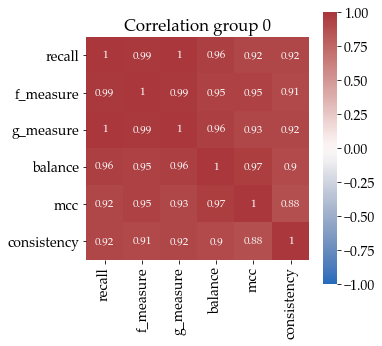

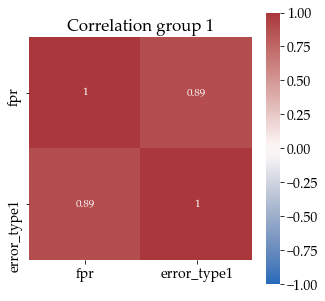

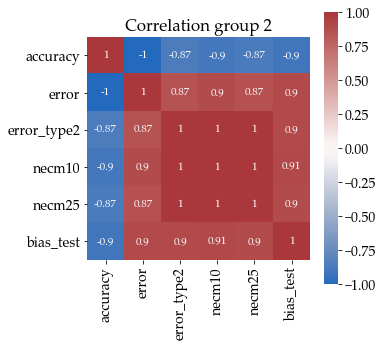

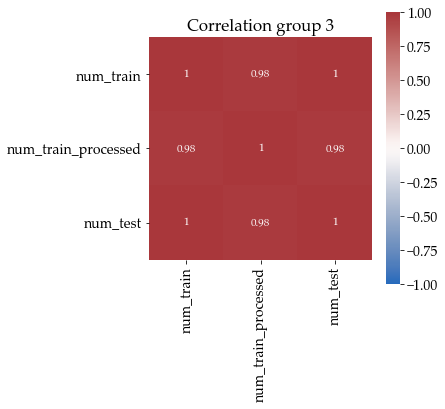

In [20]:
detect_correlation_groups(overall_spearman_corr_map, df_numeric, CORRELATION_DIR, 0.8)

### Variables vs lg(diff)

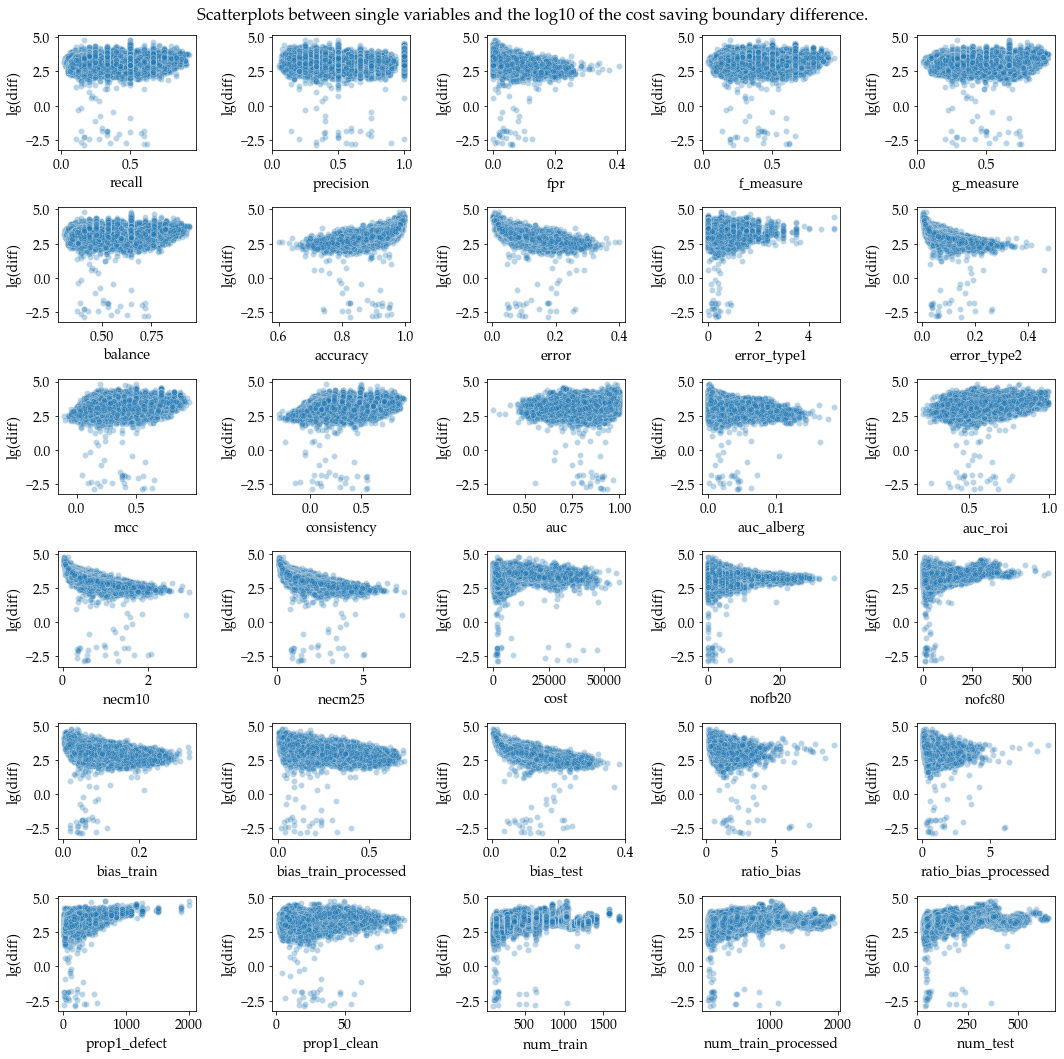

In [21]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.scatterplot(x=bt_df.iloc[:,feature_index], y=log_diff, ax=col, alpha=0.3)
        col.set_ylabel("lg(diff)")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, "scatter_log_diff" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Scatterplots between single variables and the log10 of the cost saving boundary difference.")
plt.tight_layout()
plt.show()

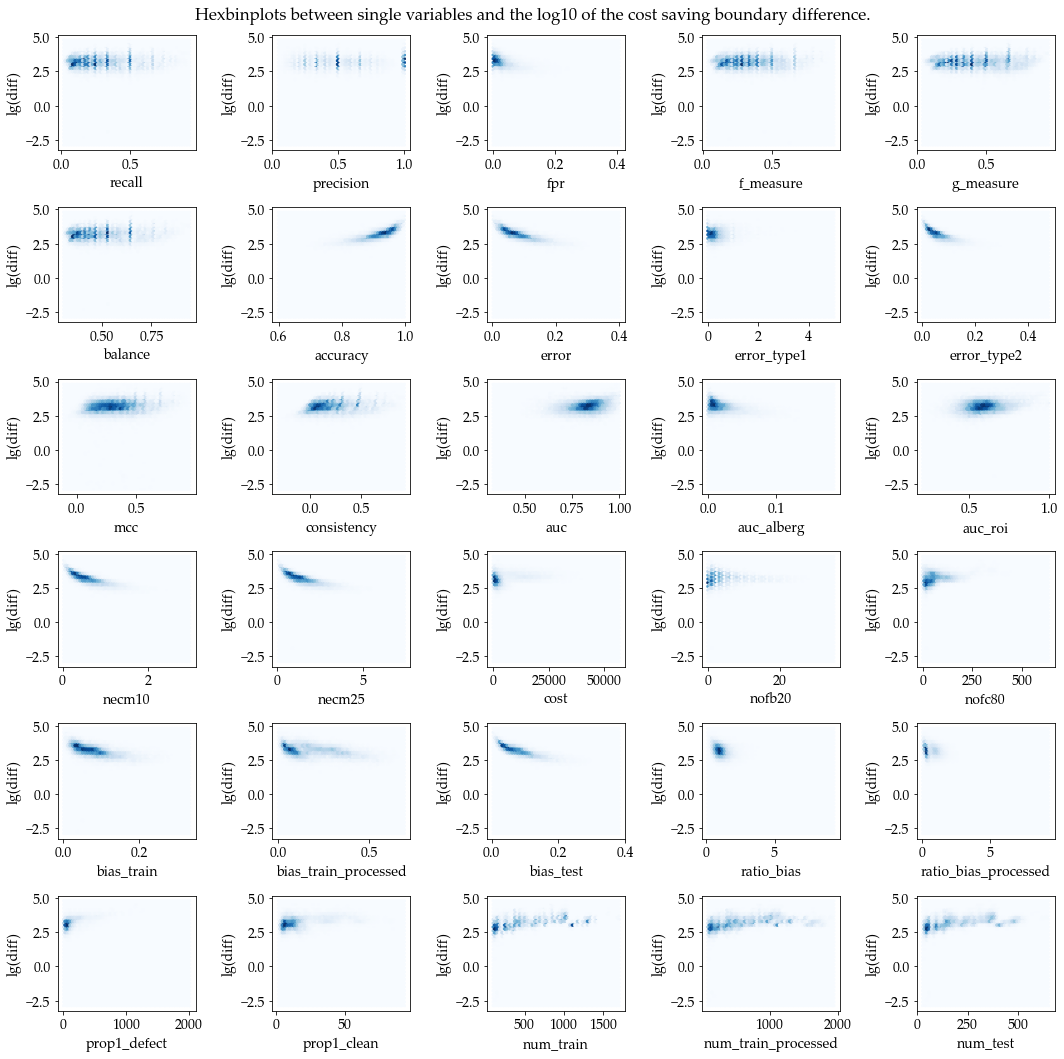

In [22]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        hb = col.hexbin(x=regular_df.iloc[:,feature_index], y=log_diff, gridsize=50, cmap='Blues')
        col.set_ylabel("lg(diff)")
        col.set_xlabel(regular_df.columns[feature_index])
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, "hexbin_log_diff" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Hexbinplots between single variables and the log10 of the cost saving boundary difference.")
plt.tight_layout()
plt.show()


### Sensitivity Analysis

In [23]:
region_medium_large = bt_df.loc[(bt_df["diff"]>900) & (bt_df["diff"]<1100)].shape[0]
print(f"Elements in boundary region medium-large [900,1100]: {region_medium_large}")
print(f"{100* region_medium_large / bt_df['potential'].value_counts()['medium']:0.1f}% of medium "
      f"and {100* region_medium_large / bt_df['potential'].value_counts()['large']:0.1f}% of large")
print()
region_large_extralarge = bt_df.loc[(bt_df["diff"]>9000) & (bt_df["diff"]<11000)].shape[0]
print(f"Instances in boundary region large-extra_large [9000,11000]: {region_large_extralarge}")
print(f"{100* region_large_extralarge / bt_df['potential'].value_counts()['large']:0.1f}% of large "
      f"and {100* region_large_extralarge / bt_df['potential'].value_counts()['extra_large']:0.1f}% of extra_large")

Elements in boundary region medium-large [900,1100]: 2338
26.0% of medium and 12.1% of large

Instances in boundary region large-extra_large [9000,11000]: 300
1.6% of large and 28.8% of extra_large


In [24]:
donwshift_conditions = [
    (bt_df['diff'] <= 0) | (bt_df['diff'] == -np.inf) | (bt_df['diff'].isnull()),
    (bt_df['diff'] > 0) & (bt_df['diff'] <= 900),
    (bt_df['diff'] > 900) & (bt_df['diff'] <= 9000),
    (bt_df['diff'] > 9000 | (bt_df['diff'] == np.inf))
    ]
upshift_conditions = [
    (bt_df['diff'] <= 0) | (bt_df['diff'] == -np.inf) | (bt_df['diff'].isnull()),
    (bt_df['diff'] > 0) & (bt_df['diff'] <= 1100),
    (bt_df['diff'] > 1100) & (bt_df['diff'] <= 11000),
    (bt_df['diff'] > 11000 | (bt_df['diff'] == np.inf))
    ]

bt_df['downshift_potential'] = np.select(donwshift_conditions, classes)
bt_df['upshift_potential'] = np.select(upshift_conditions, classes)


# 2: Evaluation Models

### Preprocessing
 - apply feature scaling
 - split dataset

In [25]:
df_features = bt_df.drop(['release', 'configuration', 'diff','potential','downshift_potential', "upshift_potential"], axis = 1)

y = bt_df['potential']
downshift_y = bt_df['downshift_potential']
upshift_y = bt_df['upshift_potential']

X_unnormed = df_features
Xmax = X_unnormed.max()
Xmin = X_unnormed.min()
X = (X_unnormed - Xmin)/(Xmax - Xmin)

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test, X_unnormed_train, X_unnormed_test, \
    downshift_y_train, downshift_y_test, upshift_y_train, upshift_y_test \
    = train_test_split(X, y, indices, X_unnormed, downshift_y, upshift_y, test_size=SPLIT_TEST_RATIO, stratify=y, random_state=RANDOM_STATE)



In [26]:
print("Number of test data instances: " + str(y_test.shape[0]) )
print("Distribution of the target variable in the test data:")
print(y_test.value_counts())

Number of test data instances: 15900
Distribution of the target variable in the test data:
none           7088
large          5800
medium         2700
extra_large     312
Name: potential, dtype: int64


In [27]:
train_df = X_train.copy(deep=True)
train_df["target"] = y_train
train_df.to_csv(os.path.join(DATA_PATH, CSV_FILENAME_TRAINING_DATA), index=False)

## 2.1: Logit model

In [28]:
if RERUN_LOGIT_OPTIMIZER:
    logit_optimizer.run_grid_search(os.path.join(DATA_PATH, CSV_FILENAME_TRAINING_DATA), os.path.join(DATA_PATH, CSV_FILENAME_LOGIT_OPTIM))

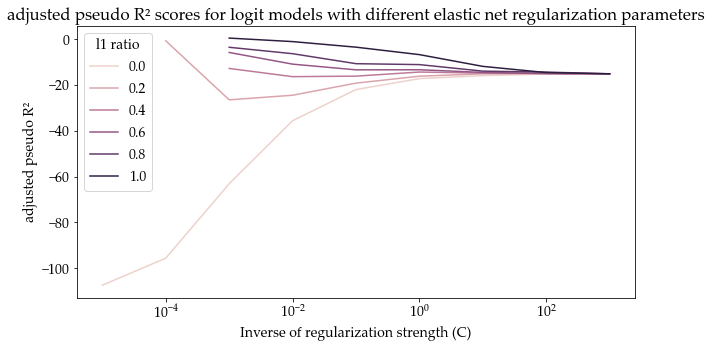

Best models sorted by adjusted pseudo R²:
         c   l1   adj_pR2  adj_weighted_pR2   num_coef
17  0.0010  1.0  0.376347          0.193968   1.000000
7   0.0001  0.2 -0.820555         -1.005843   2.000000
23  0.0100  1.0 -1.154904         -2.637264   8.666667
29  0.1000  1.0 -3.583076         -5.550886  28.000000
16  0.0010  0.8 -3.635000         -4.793452   7.000000




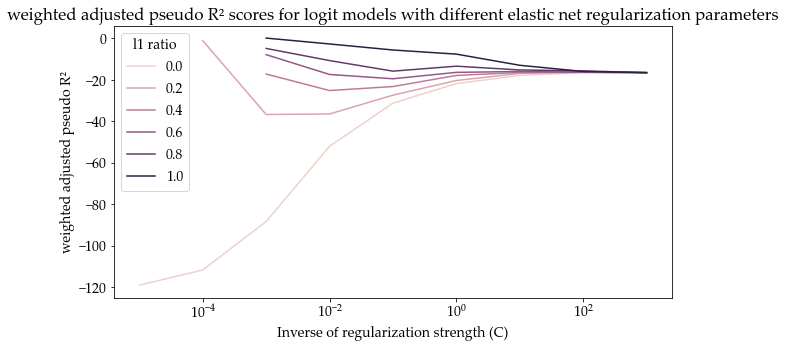

Best models sorted by weighted adjusted pseudo R²:
         c   l1   adj_pR2  adj_weighted_pR2   num_coef
17  0.0010  1.0  0.376347          0.193968   1.000000
7   0.0001  0.2 -0.820555         -1.005843   2.000000
23  0.0100  1.0 -1.154904         -2.637264   8.666667
16  0.0010  0.8 -3.635000         -4.793452   7.000000
29  0.1000  1.0 -3.583076         -5.550886  28.000000




In [29]:
optim_df = pd.read_csv(os.path.join(DATA_PATH, CSV_FILENAME_LOGIT_OPTIM))
optim_df = optim_df.loc[optim_df['adj_pR2'] != -np.inf]

plt.figure(figsize=(10, 5))
sns.lineplot(data=optim_df, x="c", y="adj_pR2", hue="l1")
plt.xscale('log')
plt.legend(title="l1 ratio")
plt.xlabel("Inverse of regularization strength (C)")
plt.ylabel("adjusted pseudo R²")
plt.savefig(os.path.join(LOGIT_OPTIM_DIR, f"optim_adj_pR2" + PLOT_FORMAT), bbox_inches='tight')
plt.title("adjusted pseudo R² scores for logit models with different elastic net regularization parameters")
plt.show()

print("Best models sorted by adjusted pseudo R²:")
print(optim_df.loc[optim_df['adj_pR2'] != -np.inf].sort_values('adj_pR2',axis=0, ascending=False).head(5))
print("\n")

plt.figure(figsize=(10, 5))
sns.lineplot(data=optim_df, x="c", y="adj_weighted_pR2", hue="l1")
plt.xscale('log')
plt.legend(title="l1 ratio")
plt.xlabel("Inverse of regularization strength (C)")
plt.ylabel("weighted adjusted pseudo R²")
plt.savefig(os.path.join(LOGIT_OPTIM_DIR, f"optim_weighted_adj_pR2" + PLOT_FORMAT), bbox_inches='tight')
plt.title("weighted adjusted pseudo R² scores for logit models with different elastic net regularization parameters")
plt.show()

print("Best models sorted by weighted adjusted pseudo R²:")
print(optim_df.loc[optim_df['adj_weighted_pR2'] != -np.inf].sort_values('adj_weighted_pR2',axis=0, ascending=False).head(5))
print("\n")

In [30]:
optim_logit_config = optim_df[optim_df['adj_pR2']==optim_df['adj_pR2'].max()]
print(f"The picked model hyperparameters are a regulation strength of {optim_logit_config.c.values[0]} and a l1-ratio of {optim_logit_config.l1.values[0]} .")

The picked model hyperparameters are a regulation strength of 0.001 and a l1-ratio of 1.0 .


C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


name             LogisticRegression
training t.                0.466027
prediction t.              0.002985
recall                     0.461759
precision                  0.374456
accuracy                   0.754654
F1 measure                 0.413442
MCC                        0.614662
dtype: object


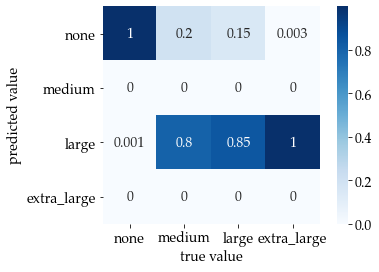

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.000000  0.848448     0.000000
moderate_overprediction   0.000000  0.804444  0.000000          NaN
overall_overprediction    0.001411  0.804444  0.000000          NaN
moderate_underprediction       NaN  0.195556  0.000000     0.996795
overall_underprediction        NaN  0.195556  0.151552     1.000000


In [31]:
model_lr = LogisticRegression(penalty="elasticnet", solver="saga", C=optim_logit_config.c.values[0], l1_ratio=optim_logit_config.l1.values[0],
                              fit_intercept=True, random_state=RANDOM_STATE, max_iter=10000)
_, metrics_df = run_model(model_lr, "LogisticRegression", X_train, y_train, X_test, y_test, metrics_df, classes)

Number of coefficients: 2 / 120


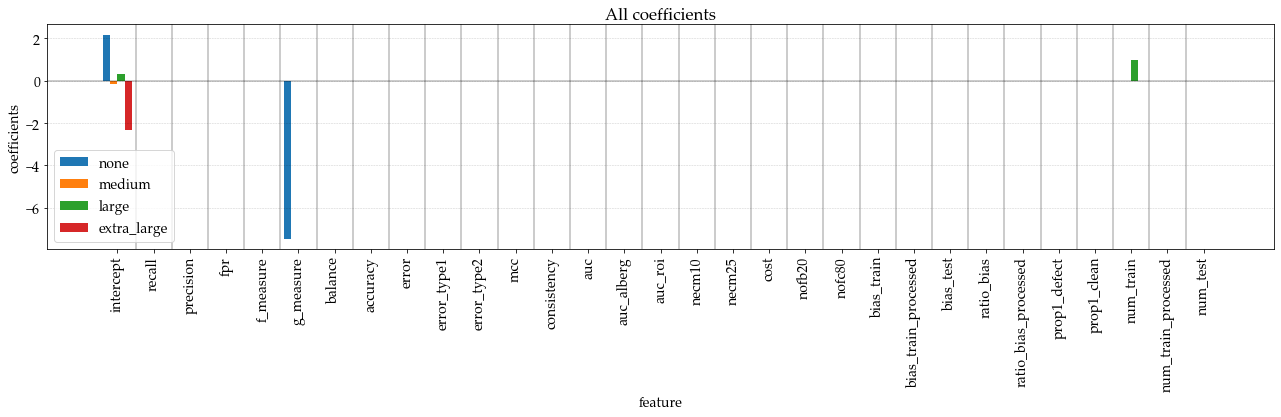

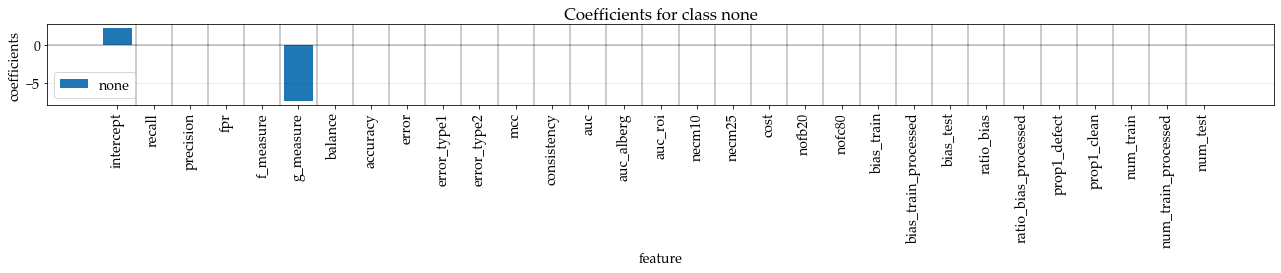

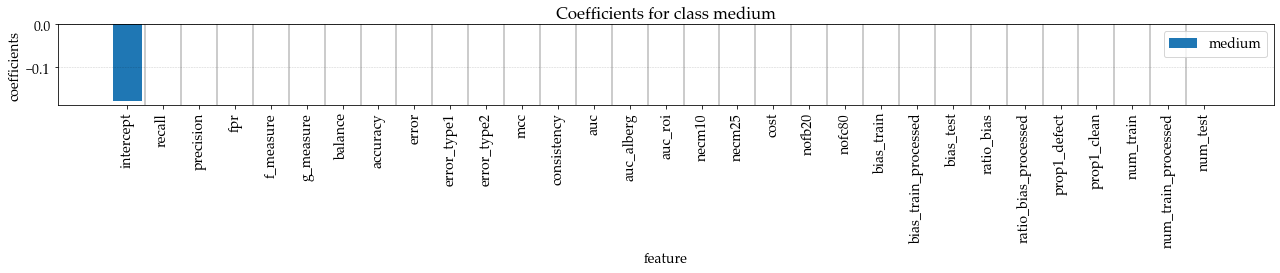

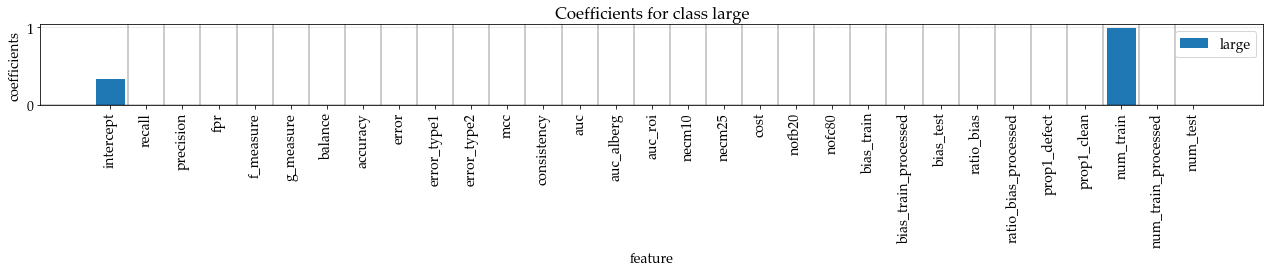

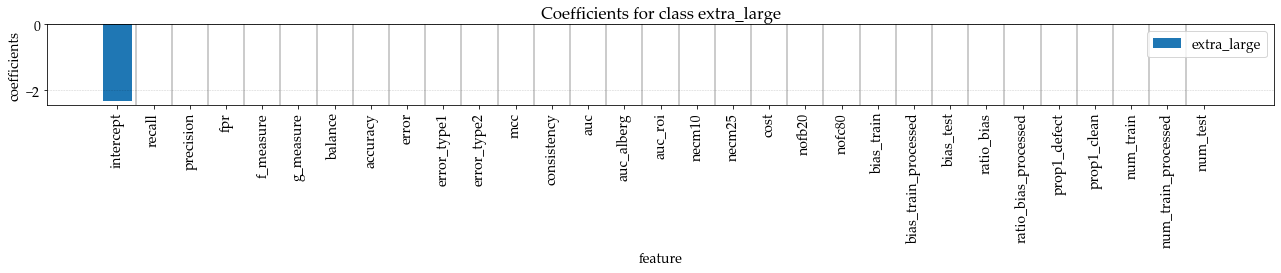

In [32]:
print(f"Number of coefficients: {np.sum(model_lr.coef_ != 0)} / {model_lr.coef_.size}")

sorted_coef = resort_coef(model_lr.coef_, model_lr.classes_, classes)
sorted_intercept = resort_coef(model_lr.intercept_, model_lr.classes_, classes)

intercept_and_coef = np.insert(sorted_coef.T, 0, sorted_intercept, axis=0).T
coef_labels = X.columns.to_list()
coef_labels.insert(0, "intercept")

bar_plot_wrapper(intercept_and_coef.T, x_labels=coef_labels, data_std=None, set_labels=classes, figsize=(18,6), filename=os.path.join(LOGIT_COEF_DIR, "coef_overall" + PLOT_FORMAT),
                 rotate_ticks=True, title=f"All coefficients")

for c, l in zip(intercept_and_coef, classes):
    c = c.reshape((c.shape[0],1))
    filename = os.path.join(LOGIT_COEF_DIR, f"coef_{l}" + PLOT_FORMAT)
    bar_plot_wrapper(c, x_labels=coef_labels, data_std=None, set_labels=[l], figsize=(18,4), rotate_ticks=True, filename=filename, title=f"Coefficients for class {l}")

## 2.2: Decision tree model

name             DecisionTree
training t.          0.303559
prediction t.        0.004969
recall               0.859244
precision            0.900657
accuracy             0.922767
F1 measure           0.876751
MCC                  0.879388
dtype: object


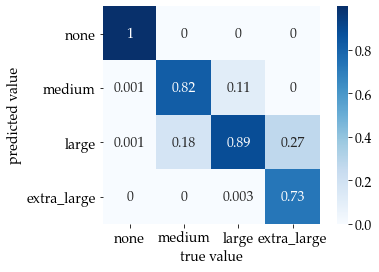

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.824444  0.886379     0.727564
moderate_overprediction   0.000847  0.175556  0.003103          NaN
overall_overprediction    0.001411  0.175556  0.003103          NaN
moderate_underprediction       NaN  0.000000  0.110517     0.272436
overall_underprediction        NaN  0.000000  0.110517     0.272436

 Text Representation of the Tree:
|--- recall <= 0.011
|   |--- class: none
|--- recall >  0.011
|   |--- accuracy <= 0.898
|   |   |--- num_train <= 527.500
|   |   |   |--- error_type2 <= 0.050
|   |   |   |   |--- consistency <= 0.944
|   |   |   |   |   |--- class: large
|   |   |   |   |--- consistency >  0.944
|   |   |   |   |   |--- class: extra_large
|   |   |   |--- error_type2 >  0.050
|   |   |   |   |--- bias_test <= 0.099
|   |   |   |   |   |--- class: medium
|   |   |   |   |--- bias_test >  0.099
|   |   |   |   |   |--- class: medium
|   |   |--- num_train >  527.500

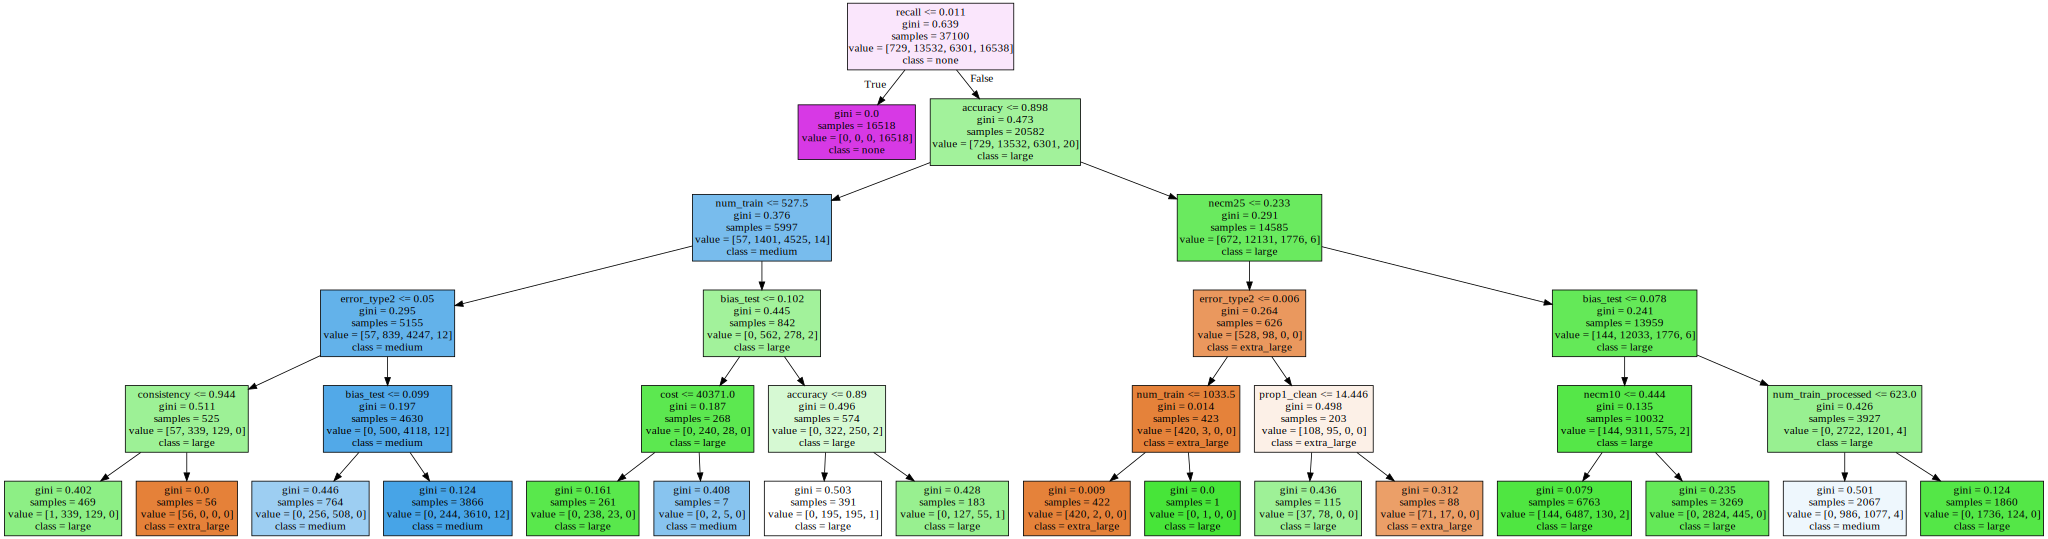

In [33]:
model_dt = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=RANDOM_STATE)
_, metrics_df = run_model(model_dt, "DecisionTree",X_unnormed_train, y_train, X_unnormed_test, y_test, metrics_df, classes)

# 1 - PRINT TEXT REPRESENTATION
print("\n Text Representation of the Tree:")
text_representation = tree.export_text(model_dt,
                                       feature_names=X_unnormed.columns.tolist(),
                                       decimals=3)

print(text_representation)

# 2 - USE GRAPHVIZ
print("decision tree graphic:")
tree.export_graphviz(model_dt,
                     out_file=os.path.join(FIGURE_PATH, 'decision_tree.dot'),
                     feature_names = X_unnormed.columns, 
                     class_names=model_dt.classes_,
                     filled = True)
dot_data = tree.export_graphviz(model_dt,
                     feature_names = X_unnormed.columns, 
                     class_names=model_dt.classes_,
                     filled = True)

#! dot -Tpdf tree.dot -o tree.pdf
os.system(f"dot -Tpdf {os.path.join(FIGURE_PATH, 'decision_tree.dot')} -o {os.path.join(FIGURE_PATH, 'decision_tree.pdf')}")

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

part of decision tree graphic:


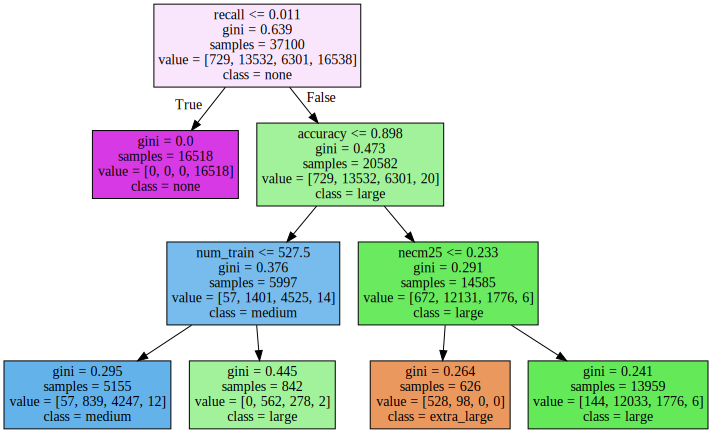

In [34]:
model_dt_cutoff = DecisionTreeClassifier(max_depth=3, criterion='gini', random_state=RANDOM_STATE)
model_dt_cutoff.fit(X=X_unnormed_train, y=y_train)

# 3 - USE GRAPHVIZ
print("part of decision tree graphic:")
tree.export_graphviz(model_dt_cutoff,
                     out_file=os.path.join(FIGURE_PATH, 'decision_tree_cutoff.dot'),
                     feature_names = X_unnormed.columns, 
                     class_names=model_dt_cutoff.classes_,
                     filled = True)
dot_data = tree.export_graphviz(model_dt_cutoff,
                     feature_names = X_unnormed.columns, 
                     class_names=model_dt_cutoff.classes_,
                     filled = True)

os.system(f"dot -Tpdf {os.path.join(FIGURE_PATH, 'decision_tree_cutoff.dot')} -o {os.path.join(FIGURE_PATH, 'decision_tree_cutoff.pdf')}")

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

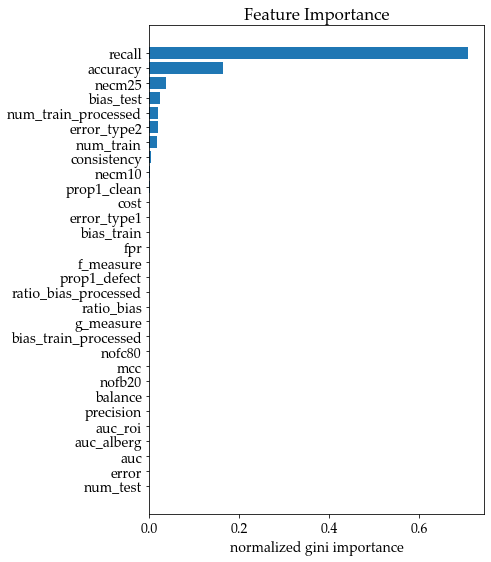

feature  importance
0                recall    0.708542
6              accuracy    0.164104
16               necm25    0.036688
22            bias_test    0.023546
28  num_train_processed    0.020580
9           error_type2    0.020052
27            num_train    0.018393
11          consistency    0.004042
15               necm10    0.002592
26          prop1_clean    0.001189
17                 cost    0.000271

In [35]:
dt_feature_importance = model_dt.tree_.compute_feature_importances(normalize=True)

dt_feat_importance_dict = {'feature': X.columns,
                      'importance': dt_feature_importance}
dt_feat_importance_df = pd.DataFrame(dt_feat_importance_dict)
dt_feat_importance_df.sort_values("importance", axis=0, ascending=False, inplace=True)


plt.figure(figsize=(6,9))
plt.barh(dt_feat_importance_df["feature"], dt_feat_importance_df["importance"])
plt.xlabel("normalized gini importance")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, "dt_feature_importance" + PLOT_FORMAT), bbox_inches="tight")
plt.title("Feature Importance")
plt.show()

dt_feat_importance_df.loc[dt_feat_importance_df['importance'] != 0]

## 2.3: Random forest model

In [36]:
def rf_optimizer_function(x, *train_data):
    """compute loss (-MCC) for Random Forest model with specific set of hyperparameters."""
    X_training, y_training = train_data
    
    min_samples_leaf = int(x[0])
    min_samples_split = int(x[1])
    max_features = x[2]
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
                                   max_features=max_features, n_jobs=-1, random_state=RANDOM_STATE)
    mcc_scorer = make_scorer(matthews_corrcoef)
    mcc_scores =cross_val_score(model, X_training, y_training, cv=3, scoring=mcc_scorer)
    return -1 * mcc_scores.mean()

t0 = time.time()
bounds = [(1,21), (2,21), (0.000001, 1.0)]
result_rf = differential_evolution(rf_optimizer_function, bounds, maxiter=3, popsize=4, mutation=0.9, recombination=0.5,
                                   init="random", strategy="rand1bin", disp=True, polish=False, seed=RANDOM_STATE,
                                   updating="immediate", tol=0.00000000001, atol=0.000000001, args=(X_train, y_train))
print(result_rf)
print(f"time needed: {time.time()-t0}")
min_s_leaf = int(result_rf.x[0])
min_s_split = int(result_rf.x[1])
max_f = result_rf.x[2]

differential_evolution step 1: f(x)= -0.912286
differential_evolution step 2: f(x)= -0.91241
differential_evolution step 3: f(x)= -0.91241
     fun: -0.9124102501512628
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 48
     nit: 3
 success: False
       x: array([ 2.16167224, 18.45734677,  0.78432688])
time needed: 227.79689264297485


name             PlainRandomForest
training t.               0.919995
prediction t.             0.053999
recall                    0.905126
precision                 0.919255
accuracy                  0.946541
F1 measure                0.911962
MCC                       0.916253
dtype: object


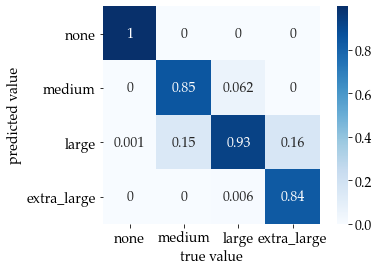

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.852963  0.932414     0.836538
moderate_overprediction   0.000423  0.147037  0.005517          NaN
overall_overprediction    0.001411  0.147037  0.005517          NaN
moderate_underprediction       NaN  0.000000  0.062069     0.163462
overall_underprediction        NaN  0.000000  0.062069     0.163462


Tuned hyperparameters:
min_samples_leaf: 2	min_samples_split: 18	max_features: 0.7843268765133742
name             TunedRandomForest
training t.               3.377533
prediction t.             0.057999
recall                    0.904453
precision                 0.920929
accuracy                   0.94717
F1 measure                0.912391
MCC                       0.917213
dtype: object


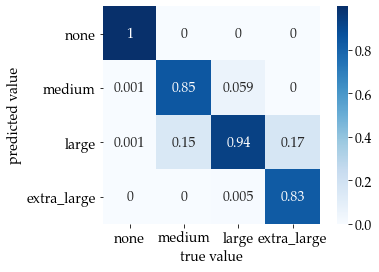

                              none   medium     large  extra_large
correctly_predicted       0.998589  0.85037  0.935517     0.833333
moderate_overprediction   0.000564  0.14963  0.005345          NaN
overall_overprediction    0.001411  0.14963  0.005345          NaN
moderate_underprediction       NaN  0.00000  0.059138     0.166667
overall_underprediction        NaN  0.00000  0.059138     0.166667


In [37]:
plain_rf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)
_, metrics_df = run_model(plain_rf, "PlainRandomForest",X_train, y_train, X_test, y_test, metrics_df, classes)

print("\n")

print(f"Tuned hyperparameters:")
print(f"min_samples_leaf: {min_s_leaf}\tmin_samples_split: {min_s_split}\tmax_features: {max_f}")
model_rf = RandomForestClassifier(min_samples_leaf=min_s_leaf, min_samples_split=min_s_split, max_features=max_f, 
                                  n_jobs=-1, random_state=RANDOM_STATE)
_, metrics_df = run_model(model_rf, "TunedRandomForest",X_train, y_train, X_test, y_test, metrics_df, classes)

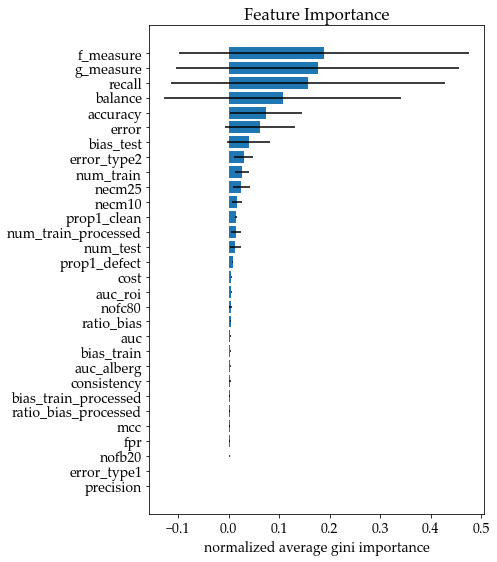

feature      mean       std
3              f_measure  0.188432  0.286452
4              g_measure  0.176087  0.280511
0                 recall  0.157233  0.270728
5                balance  0.107308  0.234338
6               accuracy  0.073244  0.071250
7                  error  0.061650  0.069525
22             bias_test  0.039548  0.042698
9            error_type2  0.029823  0.018265
27             num_train  0.026137  0.014134
16                necm25  0.025098  0.016825
15                necm10  0.016893  0.010436
26           prop1_clean  0.015224  0.002037
28   num_train_processed  0.014940  0.010632
29              num_test  0.013726  0.009989
25          prop1_defect  0.007861  0.001559
17                  cost  0.005760  0.001284
14               auc_roi  0.005531  0.001205
19                nofc80  0.004085  0.002341
23            ratio_bias  0.004032  0.000960
12                   auc  0.003870  0.000910
20            bias_train  0.003636  0.001159
13            auc_alberg  0.003529  0.000958
11           consistency  0.002629  0.001535
21  bias_train_processed  0.002626  0.000735
24  ratio_bias_processed  0.002492  0.000722
10                   mcc  0.002226  0.000842
2                    fpr  0.002125  0.000775
18                nofb20  0.001862  0.000803
8            error_type1  0.001224  0.000579
1              precision  0.001166  0.000639

In [38]:
rf_feat_importance = model_rf.feature_importances_
rf_feat_importance_std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
rf_feat_importance_dict = {'feature': X.columns,
                      'mean': rf_feat_importance,
                          'std': rf_feat_importance_std}
rf_feat_importance_df = pd.DataFrame(rf_feat_importance_dict)
rf_feat_importance_df.sort_values("mean", axis=0, ascending=False, inplace=True)

plt.figure(figsize=(6,9))
plt.barh(rf_feat_importance_df["feature"], rf_feat_importance_df["mean"], xerr=rf_feat_importance_df["std"])
plt.xlabel("normalized average gini importance")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, "rf_feature_importance" + PLOT_FORMAT), bbox_inches="tight")
plt.title("Feature Importance")
plt.show()

rf_feat_importance_df.loc[rf_feat_importance_df['mean'] != 0]

### Sensitivity Analysis Random Forest Models

differential_evolution step 1: f(x)= -0.915778
differential_evolution step 2: f(x)= -0.915778
differential_evolution step 3: f(x)= -0.915778
     fun: -0.915777624942316
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 48
     nit: 3
 success: False
       x: array([3.78987721, 7.55074832, 0.89255911])
time needed: 456.1728768348694
name             DownShiftRandomForest
training t.                   3.317573
prediction t.                 0.054997
recall                         0.90106
precision                     0.916288
accuracy                      0.948868
F1 measure                    0.908429
MCC                           0.918967
dtype: object


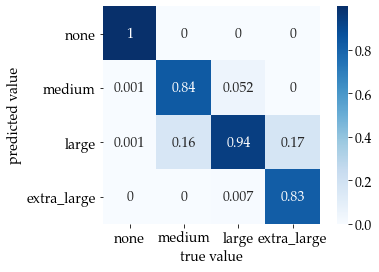

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.839286  0.940752     0.825613
moderate_overprediction   0.000564  0.160714  0.006893          NaN
overall_overprediction    0.001411  0.160714  0.006893          NaN
moderate_underprediction       NaN  0.000000  0.052355     0.174387
overall_underprediction        NaN  0.000000  0.052355     0.174387
differential_evolution step 1: f(x)= -0.914564
differential_evolution step 2: f(x)= -0.914564
differential_evolution step 3: f(x)= -0.914564
     fun: -0.9145640097471118
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 48
     nit: 3
 success: False
       x: array([3.89789744, 5.23995835, 0.54221595])
time needed: 697.9859616756439
name             UpShiftRandomForest
training t.                 3.338006
prediction t.               0.063996
recall                      0.921007
precision                   0.930485
accuracy                    0.947296
F1 measure   

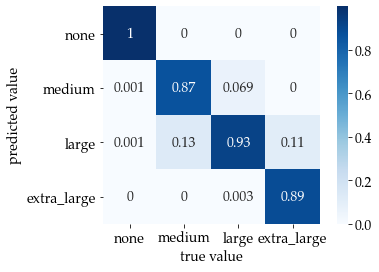

                              none   medium     large  extra_large
correctly_predicted       0.998589  0.86772  0.928013     0.889706
moderate_overprediction   0.000564  0.13228  0.003454          NaN
overall_overprediction    0.001411  0.13228  0.003454          NaN
moderate_underprediction       NaN  0.00000  0.068533     0.110294
overall_underprediction        NaN  0.00000  0.068533     0.110294


name  training t.  prediction t.    recall  precision  \
0      TunedRandomForest     3.377533       0.057999  0.904453   0.920929   
1  DownShiftRandomForest     3.317573       0.054997  0.901060   0.916288   
2    UpShiftRandomForest     3.338006       0.063996  0.921007   0.930485   

   accuracy  F1 measure       MCC  
0  0.947170    0.912391  0.917213  
1  0.948868    0.908429  0.918967  
2  0.947296    0.925643  0.918216

In [39]:
sensitivity_df = pd.DataFrame(columns=metrics_names)
sensitivity_df = sensitivity_df.append(metrics_df.loc[metrics_df['name']=='TunedRandomForest'])

result_rf_downshift = differential_evolution(rf_optimizer_function, bounds, maxiter=3, popsize=4, mutation=0.9, recombination=0.5,
                                   init="random", strategy="rand1bin", disp=True, polish=False, seed=RANDOM_STATE,
                                   updating="immediate", tol=0.00000000001, atol=0.000000001, args=(X_train, downshift_y_train))
print(result_rf_downshift)
print(f"time needed: {time.time()-t0}")
min_s_leaf = int(result_rf_downshift.x[0])
min_s_split = int(result_rf_downshift.x[1])
max_f = result_rf_downshift.x[2]

downshift_model_rf = RandomForestClassifier(min_samples_leaf=min_s_leaf, min_samples_split=min_s_split, max_features=max_f, 
                                  n_jobs=-1, random_state=RANDOM_STATE)
_, sensitivity_df = run_model(model_rf, "DownShiftRandomForest",X_train, downshift_y_train, X_test, downshift_y_test, sensitivity_df, classes)

result_rf_upshift = differential_evolution(rf_optimizer_function, bounds, maxiter=3, popsize=4, mutation=0.9, recombination=0.5,
                                   init="random", strategy="rand1bin", disp=True, polish=False, seed=RANDOM_STATE,
                                   updating="immediate", tol=0.00000000001, atol=0.000000001, args=(X_train, upshift_y_train))
print(result_rf_upshift)
print(f"time needed: {time.time()-t0}")
min_s_leaf = int(result_rf_upshift.x[0])
min_s_split = int(result_rf_upshift.x[1])
max_f = result_rf_upshift.x[2]

upshift_model_rf = RandomForestClassifier(min_samples_leaf=min_s_leaf, min_samples_split=min_s_split, max_features=max_f, 
                                  n_jobs=-1, random_state=RANDOM_STATE)
_, sensitivity_df = run_model(model_rf, "UpShiftRandomForest",X_train, upshift_y_train, X_test, upshift_y_test, sensitivity_df, classes)

sensitivity_df

# 3: Generalization


In [40]:
general_approach_list = ['1_AsIs','2_Kawata15','3_Peters15','4_Canfora13','5_Watanabe08','6_CamargoCruz09']

rs_df = pd.read_csv(os.path.join(DATA_PATH, CSV_FILENAME_GENERALIZATION), index_col=0)
print(f"Shape of the dataset: {rs_df.shape}")

dataset_overview(rs_df)

Shape of the dataset: (1698, 34)
Number of releases: 337
Instances per release: [3, 6]
Total number of instances: 1698

Overall number of NaN:               512
Overall number of NaN (no 'diff'):   434
Number of rows with NaN:             79
Number of rows with NaN (no 'diff'): 74

NaNs per variable:
consistency             72
auc                     72
auc_alberg              72
auc_roi                 72
nofc80                  72
ratio_bias_processed     2
prop1_defect            72
diff                    78
dtype: int64

infs per variable:
error_type1     72
diff           236
dtype: int64


### Evaluate and remove instances without bugs in test data or processed training data

In [41]:
rs_df = no_bugs_instances_costs(rs_df)

Number of instances without any defects in the test data: 72
Costs through QA efforts for false positives in those instances:
min: 555, max: 131291, median: 10076.50, sum: 1677909

Number of instances without any defects in the processed training data: 2
Costs through QA efforts for false positives in those instances:
min: 0, max: 0, median: 0.00, sum: 0


In [42]:
dataset_overview(rs_df)

Number of releases: 320
Instances per release: [3, 6, 5]
Total number of instances: 1624

Overall number of NaN:               5
Overall number of NaN (no 'diff'):   0
Number of rows with NaN:             5
Number of rows with NaN (no 'diff'): 0

NaNs per variable:
diff    5
dtype: int64

infs per variable:
diff    236
dtype: int64


## Descriptive Statistics and Data Visualization on Generalization Data

### Descriptive statistics of Generalization Data

In [43]:
dataset_descriptive_stats(rs_df)

configuration  release    recall  precision       fpr  f_measure  \
mean              NaN      NaN  0.524603   0.187280  0.266907   0.208165   
std               NaN      NaN  0.308252   0.168560  0.292100   0.134015   
min               NaN      NaN  0.000000   0.000000  0.000000   0.000000   
max               NaN      NaN  1.000000   1.000000  1.000000   0.727273   
median            NaN      NaN  0.500000   0.141926  0.153675   0.193801   
25q               NaN      NaN  0.280526   0.071429  0.068160   0.108723   
75q               NaN      NaN  0.760000   0.250000  0.326628   0.289705   

        g_measure   balance  accuracy     error  error_type1  error_type2  \
mean     0.467526  0.538600  0.716792  0.256421     7.979034     0.035832   
std      0.252499  0.160818  0.262635  0.213503    21.778704     0.038800   
min      0.000000  0.134187  0.002160  0.006031     0.000000     0.000000   
max      0.975207  0.965785  0.993969  0.990411   392.000000     0.254545   
median   0.520979  0.543931  0.820101  0.179899     2.660256     0.023438   
25q      0.284861  0.402373  0.673993  0.104100     0.909091     0.007277   
75q      0.665809  0.663552  0.895900  0.319161     7.289286     0.051967   

             mcc  consistency       auc  auc_alberg   auc_roi    necm10  \
mean    0.167094     0.538610  0.714163    0.006739  0.526265  0.545134   
std     0.135238     0.453845  0.138820    0.012775  0.104726  0.299007   
min    -0.365541    -0.247191  0.017964    0.000000  0.095069  0.017284   
max     0.714851     4.235294  1.000000    0.095691  1.000000  2.004505   
median  0.162962     0.484127  0.741611    0.001474  0.528006  0.495496   
25q     0.074107     0.222973  0.617819    0.000000  0.468274  0.328113   
75q     0.251028     0.748400  0.819706    0.007455  0.583504  0.715638   

          necm25           cost     nofb20       nofc80  bias_train  \
mean    1.026324   32436.504310   6.209975   257.727217    0.048148   
std     0.739903   41992.377727   7.387246   242.419340    0.020749   
min     0.035802       0.000000   0.000000     1.000000    0.005025   
max     4.977477  187780.000000  83.000000  1630.000000    0.126394   
median  0.806714   15459.000000   4.000000   179.500000    0.052798   
25q     0.521706    7362.000000   2.000000    76.000000    0.035609   
75q     1.344149   32292.000000   8.000000   365.250000    0.058598   

        bias_train_processed  bias_test  ratio_bias  ratio_bias_processed  \
mean                0.048131   0.067264    1.799216              1.802822   
std                 0.020671   0.049087    1.851994              1.878126   
min                 0.005025   0.001235    0.023526              0.023526   
max                 0.126394   0.285714   17.424007             18.949020   
median              0.052772   0.055394    1.310075              1.304679   
25q                 0.035669   0.032609    0.640672              0.640672   
75q                 0.058605   0.093023    2.204435              2.212078   

        prop1_defect  prop1_clean      num_train  num_train_processed  \
mean       96.394302    14.781421   24521.372537         24512.966749   
std       127.959585    11.298888   32894.117156         32900.216765   
min         5.678571     2.542857     100.000000            81.000000   
max      1184.000000    50.171569  128751.000000        128751.000000   
median     56.083333    10.314961    6337.000000          6337.000000   
25q        27.453125     7.894809     488.000000           457.750000   
75q       108.294118    15.925508   38396.000000         38396.000000   

           num_test         diff  potential  
mean     487.672414          NaN        NaN  
std      349.132764          NaN        NaN  
min       39.000000         -inf        NaN  
max     1708.000000          inf        NaN  
median   406.500000    78.651515        NaN  
25q      170.000000  -802.627633        NaN  
75q      708.000000  1521.491071        NaN

### Distribution of cost saving bounds difference on Generalization Data

Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns 241 instances.
Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns 709 instances.


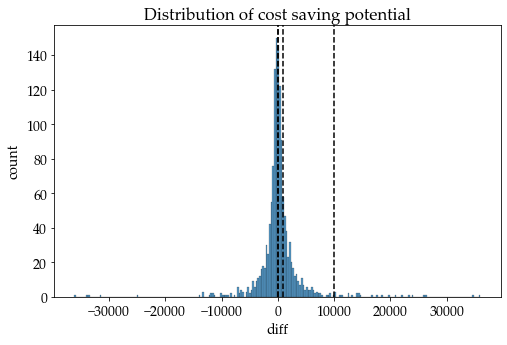

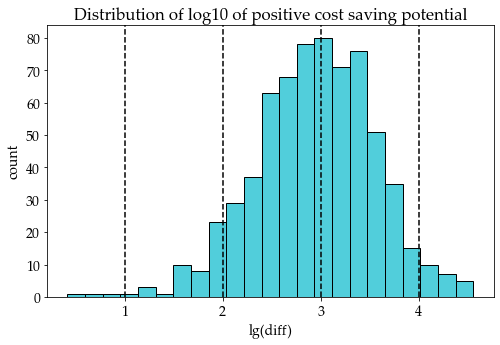

POSITIVES mean: 2.944, std: 0.609


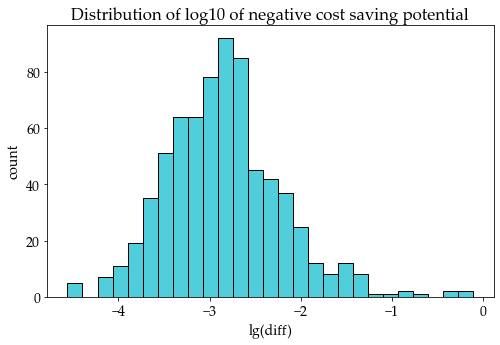

POSITIVES mean: -2.852, std: 0.634


In [44]:
regular_df = rs_df.loc[~(rs_df['diff'].isnull()) & ~(np.isinf(rs_df["diff"]))]
regular_diff = rs_df.loc[~(rs_df['diff'].isnull()) & ~(np.isinf(rs_df["diff"])), 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

print(f"Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns {rs_df.shape[0]-regular_diff.shape[0]} instances.")
print(f"Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns {neg_diff.shape[0]} instances.")


plt.figure(figsize=(8,5))
sns.histplot(data=regular_diff)
plt.ylabel("count")
plt.axvline(10, color="black", linestyle="--")
plt.axvline(100, color="black", linestyle="--")
plt.axvline(1000, color="black", linestyle="--")
plt.axvline(10000, color="black", linestyle="--")

plt.savefig(os.path.join(GENERALIZATION_DIR, "dist_diff" + PLOT_FORMAT), bbox_inches='tight')

plt.title("Distribution of cost saving potential")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(data=log_pos_diff, color="tab:cyan")
plt.ylabel("count")
plt.axvline(1, color="black", linestyle="--")
plt.axvline(2, color="black", linestyle="--")
plt.axvline(3, color="black", linestyle="--")
plt.axvline(4, color="black", linestyle="--")
plt.xlabel("lg(diff)")

plt.savefig(os.path.join(GENERALIZATION_DIR, "dist_pos_log_diff" + PLOT_FORMAT), bbox_inches='tight')

plt.title("Distribution of log10 of positive cost saving potential")
plt.show()
print(f"POSITIVES mean: {log_pos_diff.mean():0.3f}, std: {log_pos_diff.std():0.3f}")


plt.figure(figsize=(8,5))
sns.histplot(data=log_neg_diff, color="tab:cyan")
plt.ylabel("count")
plt.xlabel("lg(diff)")

plt.savefig(os.path.join(GENERALIZATION_DIR, "dist_neg_log_diff" + PLOT_FORMAT), bbox_inches='tight')

plt.title("Distribution of log10 of negative cost saving potential")
plt.show()
print(f"POSITIVES mean: {log_neg_diff.mean():0.3f}, std: {log_neg_diff.std():0.3f}")


### Distribution of dependent variable: cost saving potential on Generalization Data

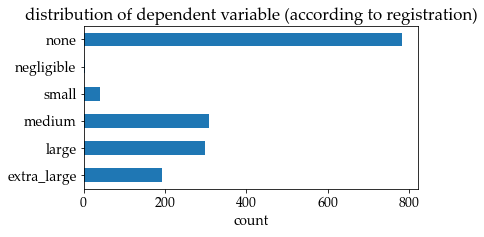

Original potential classes:
 none           783
negligible       3
small           41
medium         307
large          298
extra_large    192
Name: potential, dtype: int64 




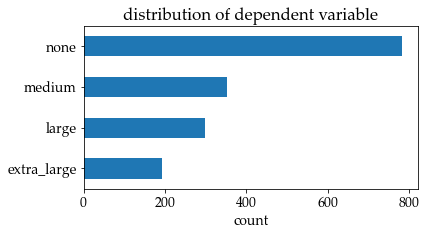

Condensed potential classes:
 none           783
medium         351
large          298
extra_large    192
Name: potential, dtype: int64 




In [45]:
original_classes = ['none','negligible','small','medium','large','extra_large']
plt.figure(figsize=(6,3))
rs_df['potential'].value_counts()[original_classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("count")
plt.savefig(os.path.join(GENERALIZATION_DIR, f"dist_dependent_original" + PLOT_FORMAT), bbox_inches='tight')
plt.title("distribution of dependent variable (according to registration)")
plt.show()
print(f"Original potential classes:\n",rs_df['potential'].value_counts()[original_classes], "\n\n")

# include 'negligible' and 'small' into 'medium'
rs_df.loc[rs_df['potential'] == 'negligible', 'potential'] = "medium"
rs_df.loc[rs_df['potential'] == 'small', 'potential'] = "medium"

classes = ['none','medium','large','extra_large']
plt.figure(figsize=(6,3))
rs_df['potential'].value_counts()[classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("count")
plt.savefig(os.path.join(GENERALIZATION_DIR, f"dist_dependent_updated" + PLOT_FORMAT), bbox_inches='tight')
plt.title("distribution of dependent variable")
plt.show()
print(f"Condensed potential classes:\n",rs_df['potential'].value_counts()[classes], "\n\n")

                none medium large extra_large
1_AsIs           101     66    50           6
2_Kawata15        83     59    74           7
3_Peters15        85     58    61          17
4_Canfora13      147     30    20         122
5_Watanabe08     217     59    32          11
6_CamargoCruz09  150     79    61          29


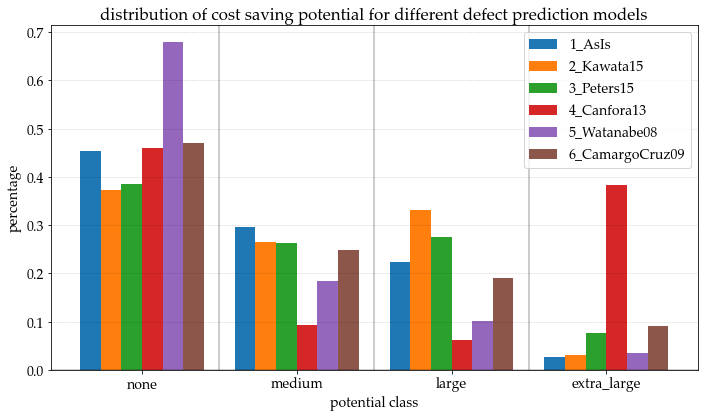

                     none    medium     large extra_large
1_AsIs           0.452915  0.295964  0.224215    0.026906
2_Kawata15       0.372197  0.264574  0.331839     0.03139
3_Peters15       0.384615  0.262443  0.276018    0.076923
4_Canfora13      0.460815  0.094044  0.062696    0.382445
5_Watanabe08     0.680251  0.184953  0.100313    0.034483
6_CamargoCruz09  0.470219  0.247649  0.191223    0.090909


In [46]:
csp_general_df = pd.DataFrame(columns=classes)
for config in general_approach_list:
    csp_general_df = csp_general_df.append(rs_df.loc[rs_df.configuration == config].potential.value_counts()[classes].rename(config))
print(csp_general_df)
csp_general_df = csp_general_df.div(csp_general_df.sum(axis=1), axis=0)

bar_plot_wrapper(csp_general_df.to_numpy().T, x_labels=classes, data_std=None,set_labels=general_approach_list, xlabel="potential class",
                 ylabel="percentage", figsize=(10,6), filename=os.path.join(GENERALIZATION_DIR, "dist_dependent_general_models" + PLOT_FORMAT),
                 rotate_ticks=False, title=f"distribution of cost saving potential for different defect prediction models")
print(csp_general_df)

### Distribution of independent and confounding variables of Generalization Data

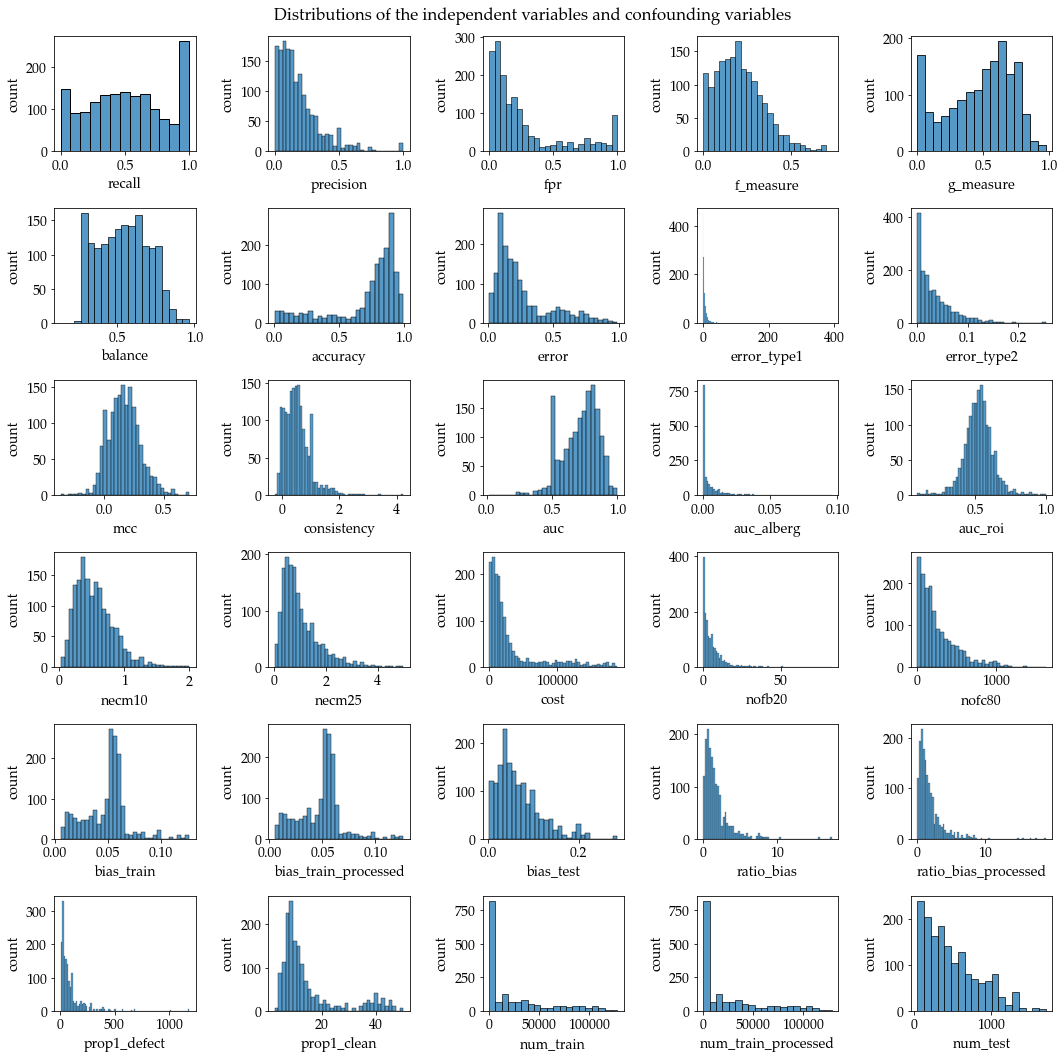

In [47]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))

feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(rs_df, x=rs_df.columns[feature_index], ax=col)
        col.set_ylabel("count")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "dist_independent_and_confounding" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Distributions of the independent variables and confounding variables")
plt.tight_layout()
plt.show()


NOTE: For computational reasons all 0 values in this plot are replaced by 1e-3.


C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


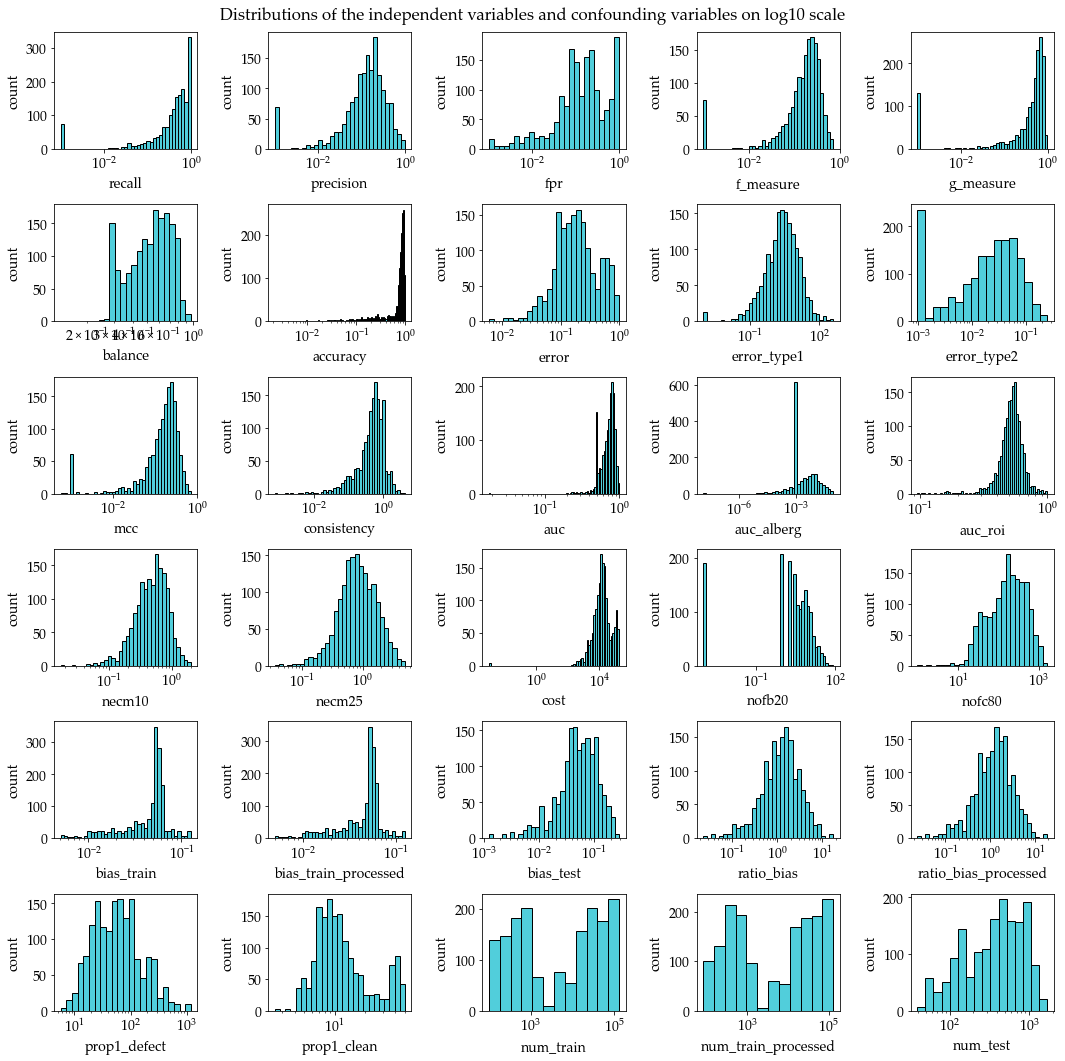

In [48]:
rs_df_4_log = rs_df.copy(deep=True)
rs_df_4_log.replace(to_replace=0, value=0.001, inplace=True)
print("NOTE: For computational reasons all 0 values in this plot are replaced by 1e-3.")

fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        if rs_df_4_log[rs_df.columns[feature_index]].min() == 0:
            print(rs_df_4_log.columns[feature_index], rs_df_4_log[rs_df.columns[feature_index]].min())
        sns.histplot(rs_df_4_log, x=rs_df_4_log.columns[feature_index], color="tab:cyan", ax=col, log_scale=True)
        col.set_xlabel(rs_df.columns[feature_index])
        col.set_ylabel("count")
        feature_index += 1

plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "dist_log_independent_and_confounding" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Distributions of the independent variables and confounding variables on log10 scale")
plt.tight_layout()
plt.show()

### Boxplots

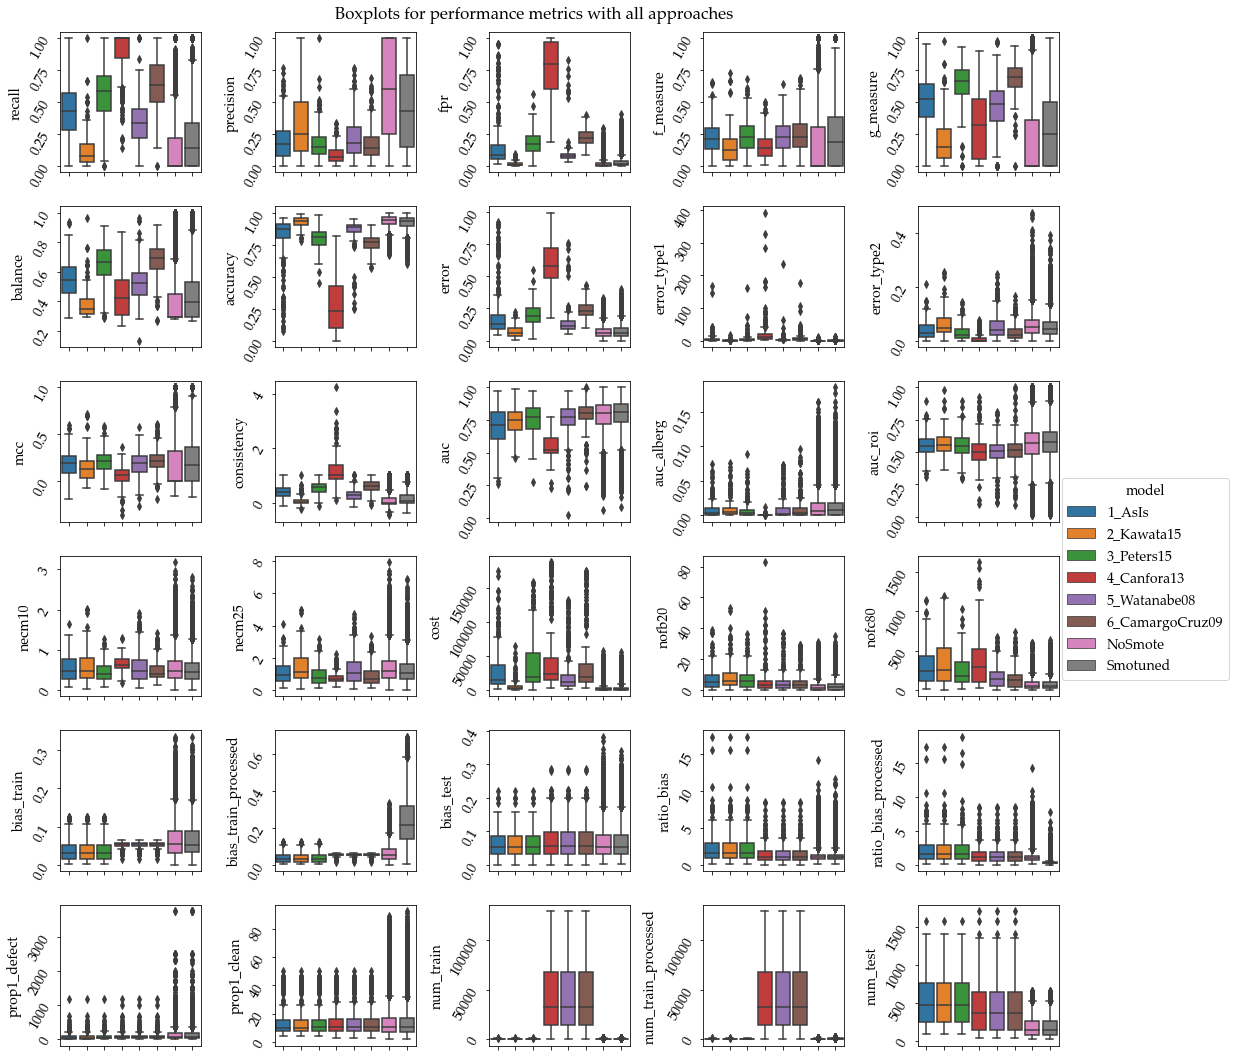

In [49]:
full_df = rs_df.append(bt_df)
full_approach_list = general_approach_list + ['NoSmote','Smotuned']
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
first_flag = True
for row in axes:
    for col in row:
        if first_flag:
            sns.boxplot(x=full_df.iloc[:,0], y=full_df.iloc[:,feature_index], hue=full_df.iloc[:,0], ax=col,
               order=full_approach_list, hue_order=full_approach_list)
            col.get_legend().remove()
            handles, labels = col.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15,0.55), title="model")
            col.clear()
            first_flag = False
        sns.boxplot(x=full_df.iloc[:,0], y=full_df.iloc[:,feature_index], ax=col, order=full_approach_list)
        col.set(xticklabels=[])  # remove the tick labels
        col.set(xlabel=None)
        col.tick_params(labelrotation=60)
        feature_index += 1
     
plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "boxplot_all_approaches" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Boxplots for performance metrics with all approaches")
plt.tight_layout()
plt.show()

#### Log Boxplots

NOTE: For computational reasons all 0 values in this plot are replaced by 1e-3.


C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


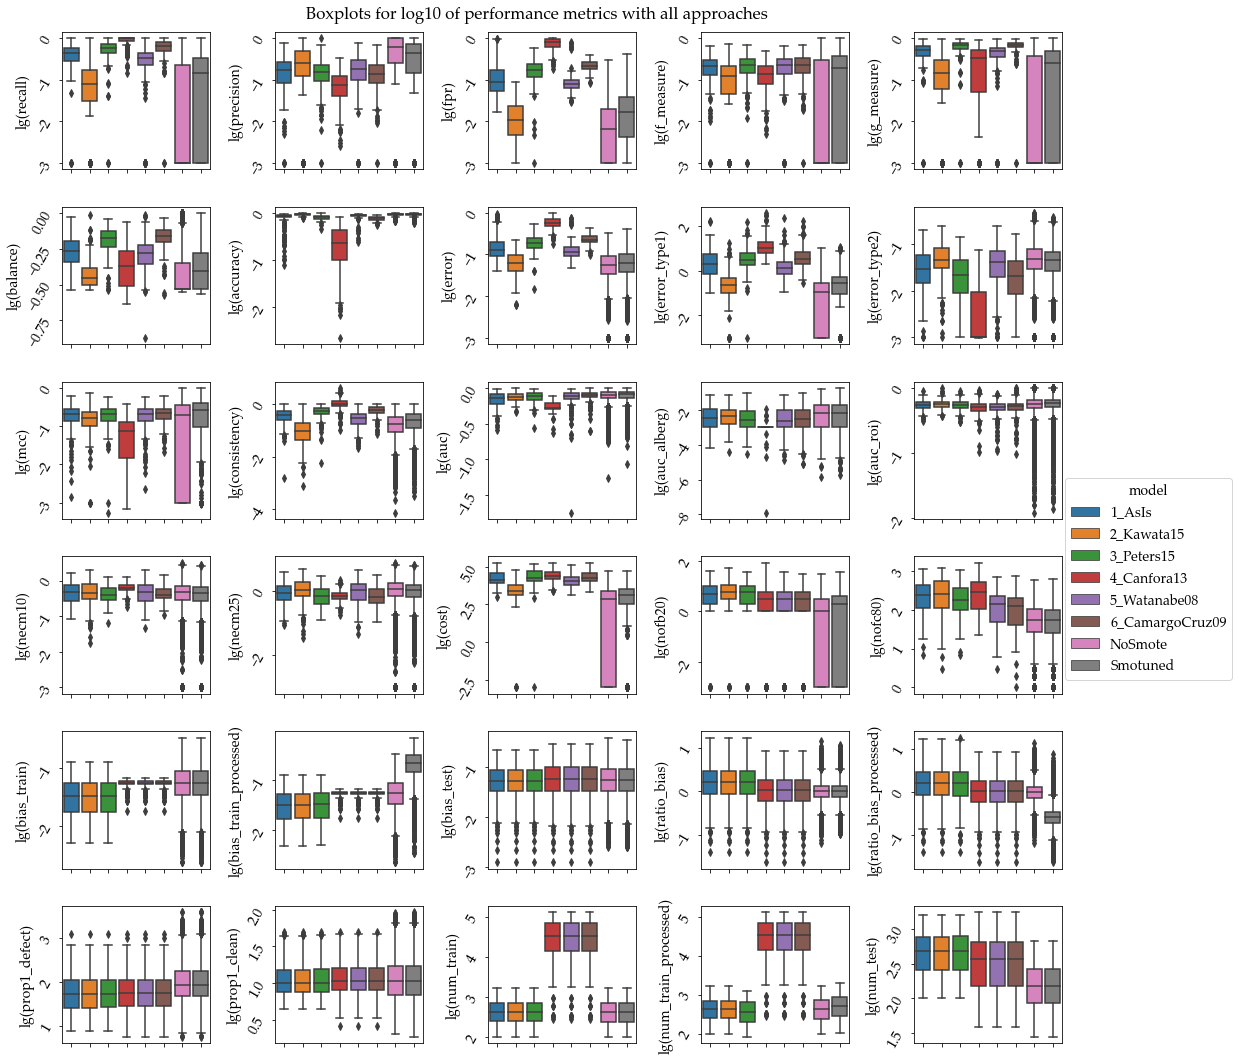

In [50]:
full_df_4_log = full_df.copy(deep=True)
full_df_4_log.replace(to_replace=0, value=0.001, inplace=True)
print("NOTE: For computational reasons all 0 values in this plot are replaced by 1e-3.")

fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
first_flag = True
for row in axes:
    for col in row:
        if first_flag:
            sns.boxplot(x=full_df_4_log.iloc[:,0], y=full_df_4_log.iloc[:,feature_index], hue=full_df_4_log.iloc[:,0], ax=col,
                        order=full_approach_list, hue_order=full_approach_list)
            col.get_legend().remove()
            handles, labels = col.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15,0.55), title="model")
            col.clear()
            first_flag = False
        sns.boxplot(x=full_df_4_log.iloc[:,0], y=np.log10(full_df_4_log.iloc[:,feature_index]), ax=col, order=full_approach_list)
        col.set(xticklabels=[])  # remove the tick labels
        col.set(xlabel=None)
        col.set_ylabel(f"lg({full_df_4_log.columns[feature_index]})")
        col.tick_params(labelrotation=60)
        feature_index += 1

plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "boxplot_log_all_approaches" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Boxplots for log10 of performance metrics with all approaches")
plt.tight_layout()
plt.show()

### Correlation Analysis on Generalization Data

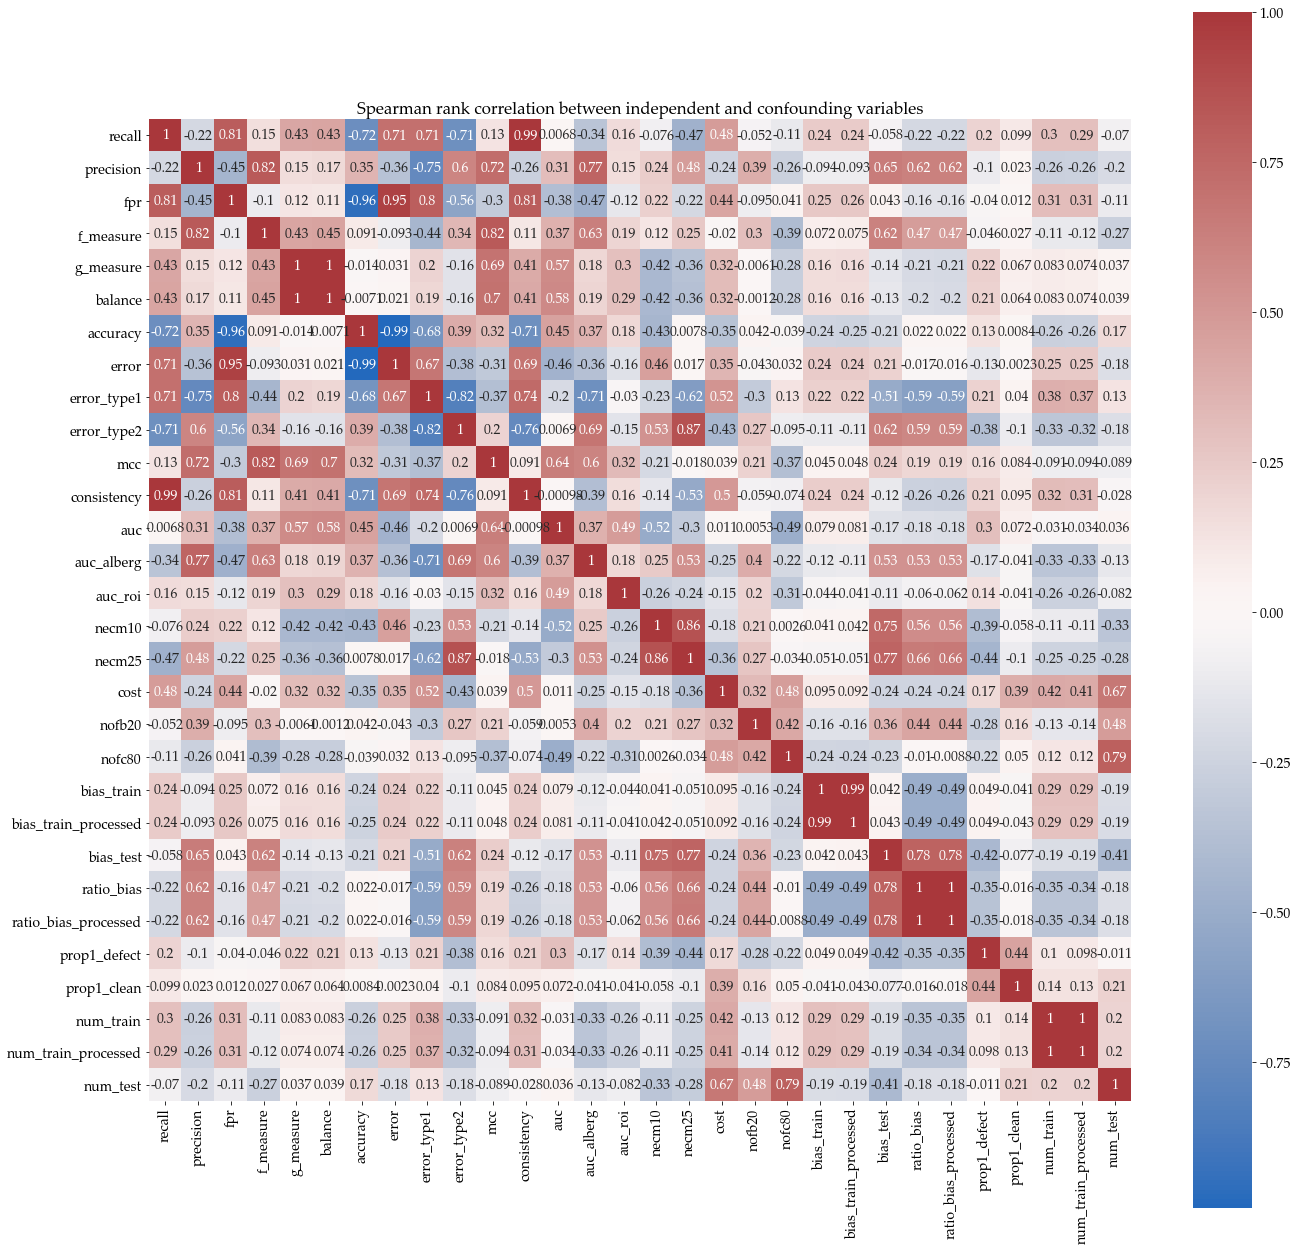

In [51]:
rs_df_numeric = rs_df.iloc[:,FIRST_NUM_FEATURE_IDX:FIRST_NUM_FEATURE_IDX+30]
overall_spearman_corr_map_real = spearmanr(a=rs_df_numeric).correlation

plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map_real, square=True, annot=True, xticklabels=rs_df_numeric.columns, yticklabels=rs_df_numeric.columns, cmap="vlag")

plt.savefig(os.path.join(GENERALIZATION_DIR, "corr_all" + PLOT_FORMAT), bbox_inches='tight')

plt.title("Spearman rank correlation between independent and confounding variables")
plt.show()

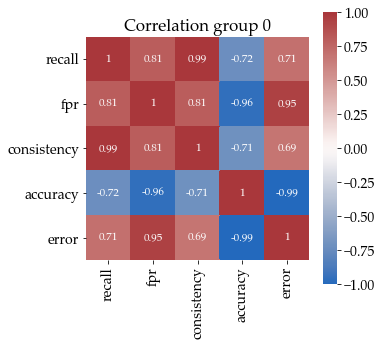

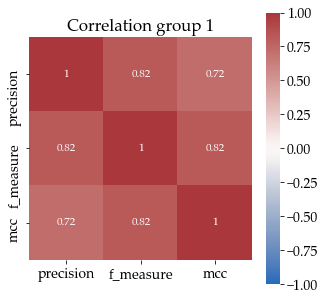

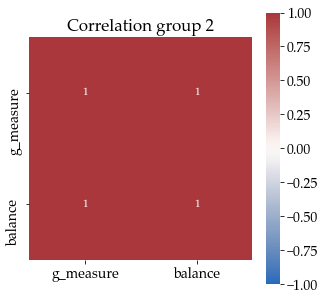

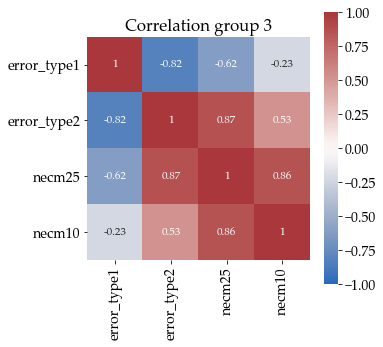

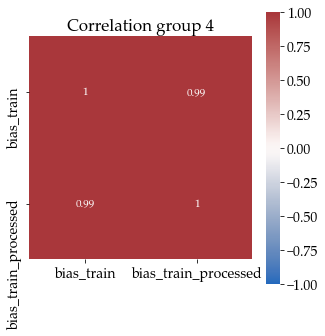

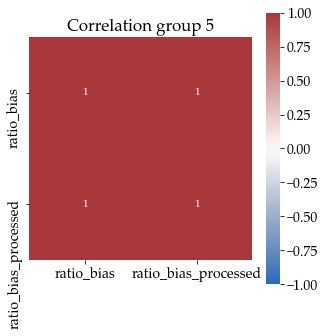

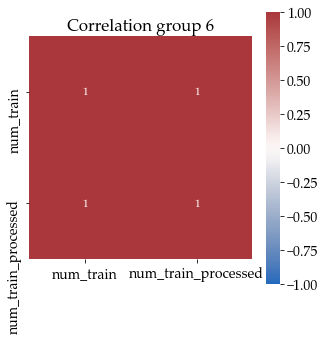

In [52]:
detect_correlation_groups(overall_spearman_corr_map_real, rs_df_numeric, GENERALIZATION_DIR, CORRELATION_THRESHOLD)

### Variables cs lg(diff) on Generalization Data

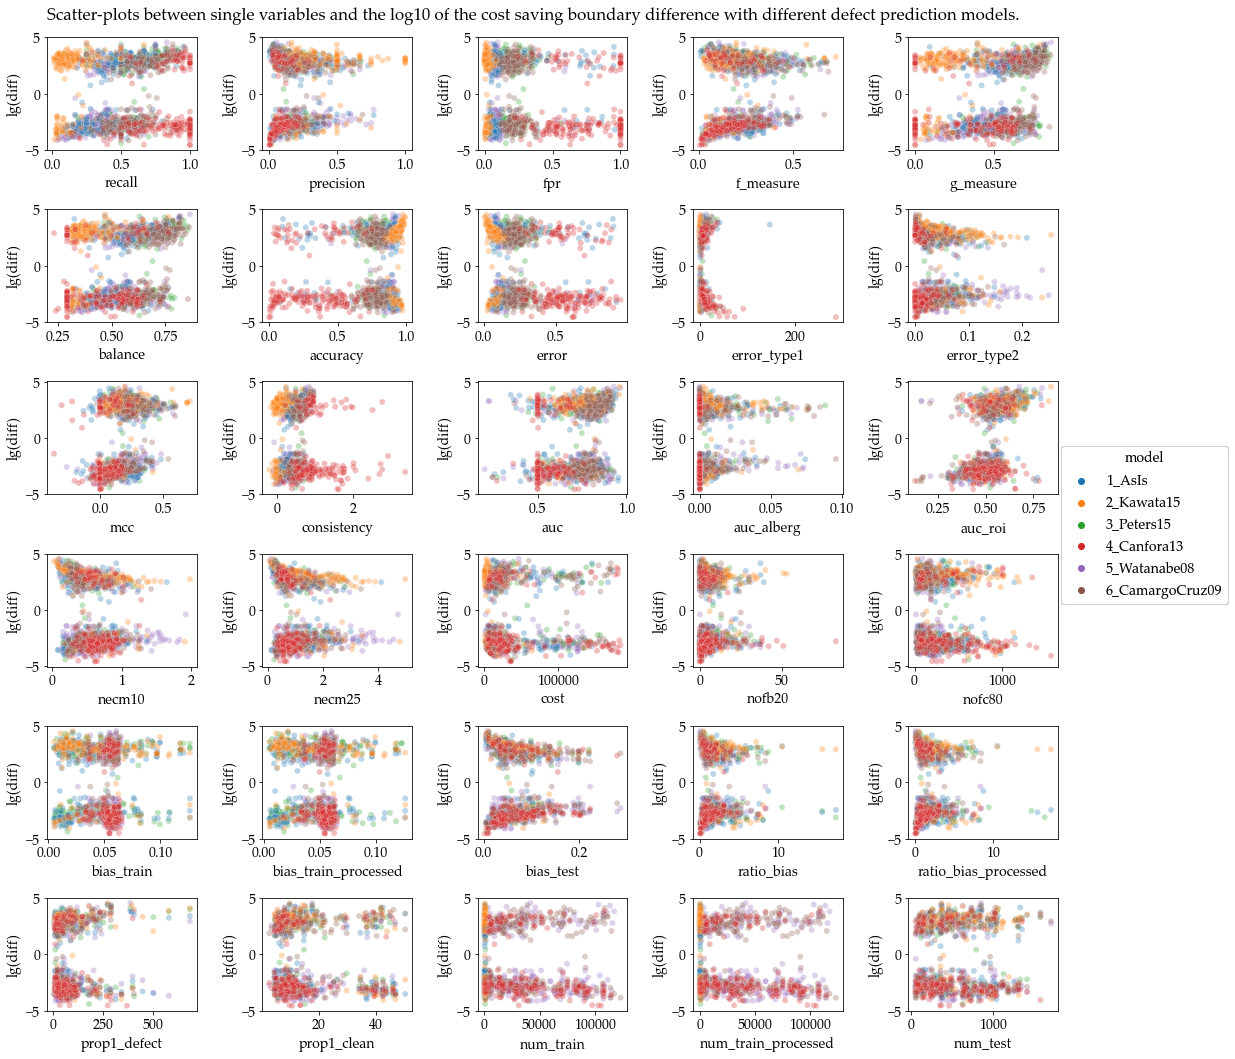

In [53]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        col = sns.scatterplot(x=rs_df.iloc[:,feature_index], y=log_diff, ax=col, alpha=0.3, hue=rs_df.iloc[:,0],
                              hue_order=general_approach_list)
        col.set_ylabel("lg(diff)")
        col.get_legend().remove()
        handles, labels = col.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15,0.58), title="model")
        feature_index += 1

plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "scatter_log_diff_grouped" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Scatter-plots between single variables and the log10 of the cost saving boundary difference with different defect prediction models.")
plt.tight_layout()
plt.show()

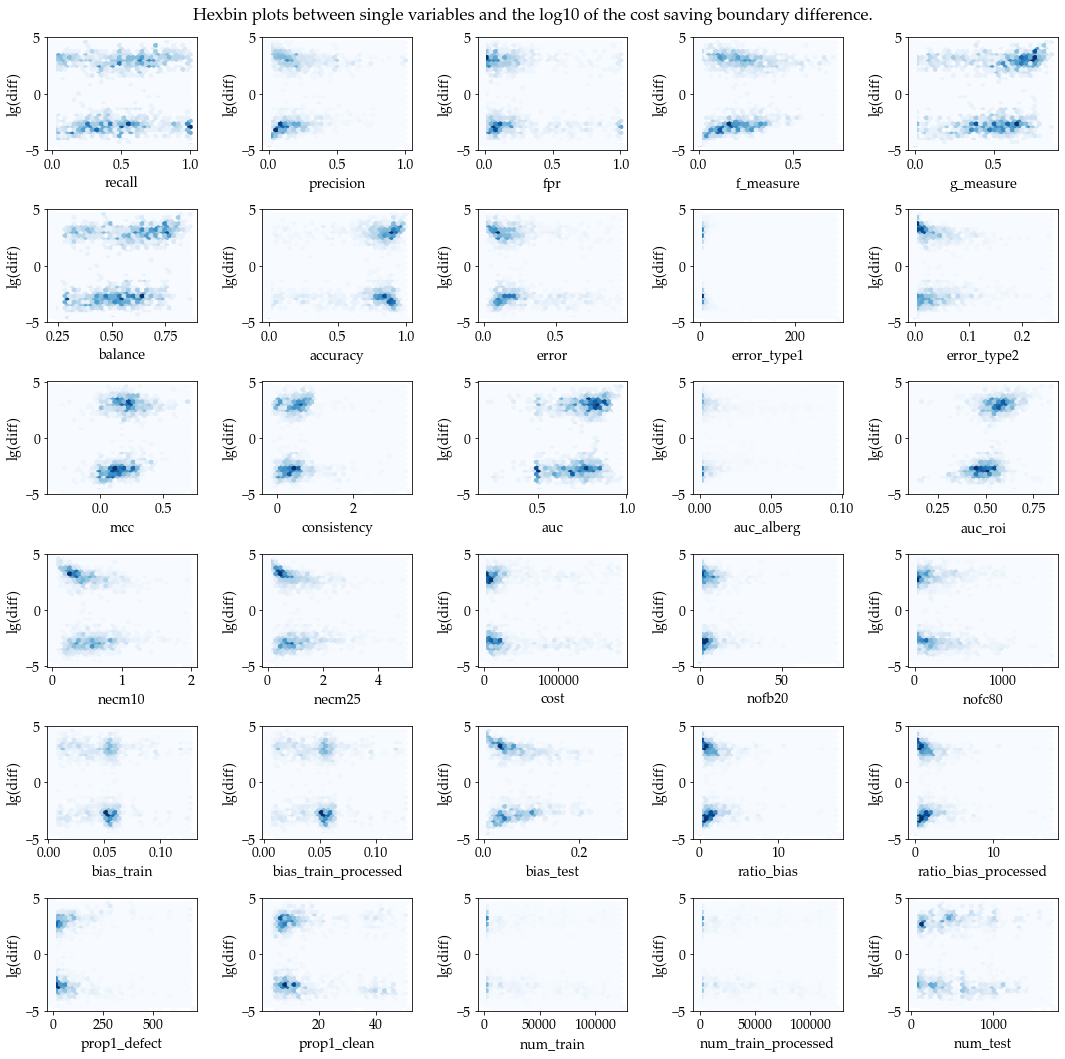

In [54]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        hb = col.hexbin(x=regular_df.iloc[:,feature_index], y=log_diff, gridsize=30, cmap='Blues', marginals=True)
        col.set_ylabel("lg(diff)")
        col.set_xlabel(regular_df.columns[feature_index])
        feature_index += 1

plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "hexbin_log_diff" + PLOT_FORMAT), bbox_inches='tight')

fig.suptitle("Hexbin plots between single variables and the log10 of the cost saving boundary difference.")
plt.tight_layout()
plt.show()

### Sensitivity Analysis on Generalization Data

In [55]:
region_medium_large = rs_df.loc[(rs_df["diff"]>900) & (rs_df["diff"]<1100)].shape[0]
print(f"Elements in boundary region medium-large [900,1100]: {region_medium_large}")
print(f"{100* region_medium_large / rs_df['potential'].value_counts()['medium']:0.1f}% of medium "
      f"and {100* region_medium_large / rs_df['potential'].value_counts()['large']:0.1f}% of large")
print()
region_large_extralarge = rs_df.loc[(rs_df["diff"]>9000) & (rs_df["diff"]<11000)].shape[0]
print(f"Instances in boundary region large-extra_large [9000,11000]: {region_large_extralarge}")
print(f"{100* region_large_extralarge / rs_df['potential'].value_counts()['large']:0.1f}% of large "
      f"and {100* region_large_extralarge / rs_df['potential'].value_counts()['extra_large']:0.1f}% of extra_large")

Elements in boundary region medium-large [900,1100]: 34
9.7% of medium and 11.4% of large

Instances in boundary region large-extra_large [9000,11000]: 7
2.3% of large and 3.6% of extra_large


## Test Models on Generalization Data

In [56]:
rs_df_features = rs_df.drop(['release', 'configuration', 'diff','potential'], axis = 1)

y_real = rs_df['potential']
X_real_unnormed = rs_df_features

Xmax_real = X_real_unnormed.max()
Xmin_real = X_real_unnormed.min()
X_real = (X_real_unnormed - Xmin_real)/(Xmax_real - Xmin_real)

name             GeneralLogisticRegression
training t.                              0
prediction t.                            0
recall                            0.270677
precision                         0.187516
accuracy                          0.268473
F1 measure                         0.16167
MCC                               0.052025
dtype: object


C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


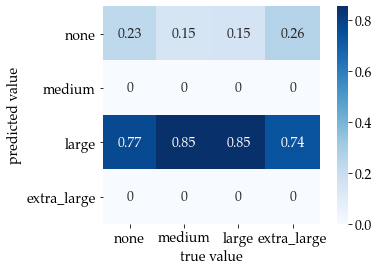

                              none    medium     large  extra_large
correctly_predicted       0.233716  0.000000  0.848993     0.000000
moderate_overprediction   0.000000  0.851852  0.000000          NaN
overall_overprediction    0.766284  0.851852  0.000000          NaN
moderate_underprediction       NaN  0.148148  0.000000     0.739583
overall_underprediction        NaN  0.148148  0.151007     1.000000


In [57]:
y_real_model = model_lr.predict(X_real)
metrics_df = metrics_df.append(performance_eval(y_real_model, y_real, classes, name="GeneralLogisticRegression", df=metrics_df, save_dir=GENERALIZATION_DIR), ignore_index=True)

name             GeneralDecisionTree
training t.                        0
prediction t.                      0
recall                      0.340273
precision                   0.567115
accuracy                    0.279557
F1 measure                   0.26137
MCC                         0.137035
dtype: object


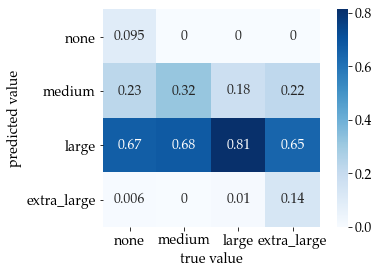

                              none    medium     large  extra_large
correctly_predicted       0.094508  0.319088  0.812081     0.135417
moderate_overprediction   0.229885  0.680912  0.010067          NaN
overall_overprediction    0.905492  0.680912  0.010067          NaN
moderate_underprediction       NaN  0.000000  0.177852     0.645833
overall_underprediction        NaN  0.000000  0.177852     0.864583


In [58]:
y_real_model = model_dt.predict(X_real_unnormed)
metrics_df = metrics_df.append(performance_eval(y_real_model, y_real, classes, name="GeneralDecisionTree", df=metrics_df, save_dir=GENERALIZATION_DIR), ignore_index=True)

name             GeneralRandomForest
training t.                        0
prediction t.                      0
recall                      0.433272
precision                   0.559122
accuracy                    0.347906
F1 measure                  0.353368
MCC                         0.218451
dtype: object


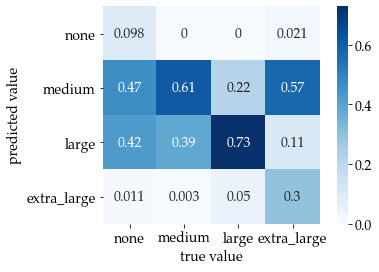

                              none    medium     large  extra_large
correctly_predicted       0.098340  0.609687  0.728188     0.296875
moderate_overprediction   0.464879  0.387464  0.050336          NaN
overall_overprediction    0.901660  0.390313  0.050336          NaN
moderate_underprediction       NaN  0.000000  0.221477     0.109375
overall_underprediction        NaN  0.000000  0.221477     0.703125


In [59]:
y_real_model = model_rf.predict(X_real)
metrics_df = metrics_df.append(performance_eval(y_real_model, y_real, classes, name="GeneralRandomForest", df=metrics_df, save_dir=GENERALIZATION_DIR), ignore_index=True)

### model performance overview

In [60]:
metrics_df

name  training t.  prediction t.    recall  precision  \
0         LogisticRegression     0.466027       0.002985  0.461759   0.374456   
1               DecisionTree     0.303559       0.004969  0.859244   0.900657   
2          PlainRandomForest     0.919995       0.053999  0.905126   0.919255   
3          TunedRandomForest     3.377533       0.057999  0.904453   0.920929   
4  GeneralLogisticRegression     0.000000       0.000000  0.270677   0.187516   
5        GeneralDecisionTree     0.000000       0.000000  0.340273   0.567115   
6        GeneralRandomForest     0.000000       0.000000  0.433272   0.559122   

   accuracy  F1 measure       MCC  
0  0.754654    0.413442  0.614662  
1  0.922767    0.876751  0.879388  
2  0.946541    0.911962  0.916253  
3  0.947170    0.912391  0.917213  
4  0.268473    0.161670  0.052025  
5  0.279557    0.261370  0.137035  
6  0.347906    0.353368  0.218451

# 4: Theory Building

## Theory based on Bootstrap Experiment

name             TheoryModel
training t.                0
prediction t.              0
recall              0.847346
precision            0.85311
accuracy            0.906478
F1 measure          0.850183
MCC                 0.853575
dtype: object


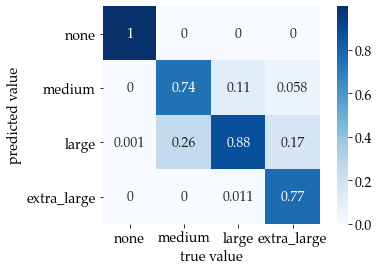

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.745185  0.876379     0.769231
moderate_overprediction   0.000423  0.254815  0.010862          NaN
overall_overprediction    0.001411  0.254815  0.010862          NaN
moderate_underprediction       NaN  0.000000  0.112759     0.173077
overall_underprediction        NaN  0.000000  0.112759     0.230769


In [61]:
theory_conditions = [
    (bt_df['recall'] <  0.01),
    (bt_df['recall'] >= 0.01) & (bt_df['accuracy'] <  0.90),
    (bt_df['recall'] >= 0.01) & (bt_df['accuracy'] >= 0.90) & (bt_df['necm25'] > 0.25),
    (bt_df['recall'] >= 0.01) & (bt_df['accuracy'] >= 0.90) & (bt_df['necm25'] <= 0.25)]
bt_df['theory_potential'] = np.select(theory_conditions, classes)

metrics_df = metrics_df.append(performance_eval(bt_df['theory_potential'][idx_test], y_test, classes, name="TheoryModel", df=metrics_df), ignore_index=True)

name             ExactTheoryModel
training t.                     0
prediction t.                   0
recall                   0.842661
precision                0.861787
accuracy                 0.908302
F1 measure               0.851769
MCC                      0.856195
dtype: object


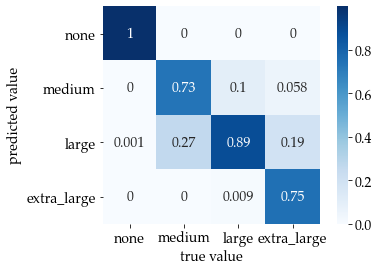

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.734815  0.887241     0.750000
moderate_overprediction   0.000423  0.265185  0.008966          NaN
overall_overprediction    0.001411  0.265185  0.008966          NaN
moderate_underprediction       NaN  0.000000  0.103793     0.192308
overall_underprediction        NaN  0.000000  0.103793     0.250000


In [62]:
theory_conditions_exact = [
    (bt_df['recall'] <  0.011),
    (bt_df['recall'] >= 0.011) & (bt_df['accuracy'] <  0.898),
    (bt_df['recall'] >= 0.011) & (bt_df['accuracy'] >= 0.898) & (bt_df['necm25'] > 0.233),
    (bt_df['recall'] >= 0.011) & (bt_df['accuracy'] >= 0.898) & (bt_df['necm25'] <= 0.233)]
bt_df['exact_theory_potential'] = np.select(theory_conditions_exact, classes)
metrics_df = metrics_df.append(performance_eval(bt_df['exact_theory_potential'][idx_test], y_test, classes, name="ExactTheoryModel", df=metrics_df), ignore_index=True)

## Apply Theory on Generalization Data

name             GeneralTheoryModel
training t.                       0
prediction t.                     0
recall                     0.339694
precision                  0.524264
accuracy                    0.29803
F1 measure                 0.263387
MCC                        0.150161
dtype: object


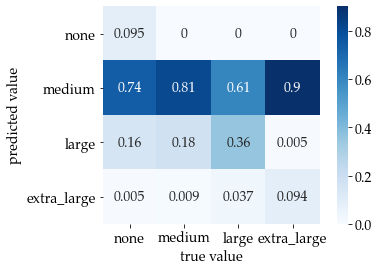

                              none    medium     large  extra_large
correctly_predicted       0.094508  0.814815  0.355705     0.093750
moderate_overprediction   0.743295  0.176638  0.036913          NaN
overall_overprediction    0.905492  0.185185  0.036913          NaN
moderate_underprediction       NaN  0.000000  0.607383     0.005208
overall_underprediction        NaN  0.000000  0.607383     0.906250


In [63]:
theory_conditions_for_rs_df = [
    (rs_df['recall'] <  0.01),
    (rs_df['recall'] >= 0.01) & (rs_df['accuracy'] <  0.90),
    (rs_df['recall'] >= 0.01) & (rs_df['accuracy'] >= 0.90) & (rs_df['necm25'] > 0.25),
    (rs_df['recall'] >= 0.01) & (rs_df['accuracy'] >= 0.90) & (rs_df['necm25'] <= 0.25)]
rs_df['theory_potential'] = np.select(theory_conditions_for_rs_df, classes)

metrics_df = metrics_df.append(performance_eval(rs_df['theory_potential'], y_real, classes, name="GeneralTheoryModel", df=metrics_df), ignore_index=True)

### relation between recall and unregular none instances

In [64]:
bt_ninf_or_nan = bt_df.loc[(np.isnan(bt_df['diff'])) | (bt_df['diff']==-np.inf)]
print(f"Bootstrap instances:                                                    {bt_df.shape[0]}")
print(f"Bootstrap instances that have a potential of none:                      {bt_df.loc[bt_df['potential']=='none'].shape[0]}")
print(f"Bootstrap instances that have a diff of NaN or -inf:                    {bt_ninf_or_nan.shape[0]}")
print(f"Bootstrap instances that have a recall < 0.00001:                       {bt_df.loc[bt_df['recall']<0.00001].shape[0]}")
print(f"Bootstrap instances that have a potential of none and recall < 0.00001: {bt_ninf_or_nan.loc[bt_ninf_or_nan['recall']<0.00001].shape[0]}")

rs_ninf_or_nan = rs_df.loc[(np.isnan(rs_df['diff'])) | (rs_df['diff']==-np.inf)]
print(f"Generalization instances:                                                    {rs_df.shape[0]}")
print(f"Generalization instances that have a potential of none:                      {rs_df.loc[rs_df['potential']=='none'].shape[0]}")
print(f"Generalization instances that have a diff of NaN or -inf:                    {rs_ninf_or_nan.shape[0]}")
print(f"Generalization instances that have a recall < 0.00001:                       {rs_df.loc[rs_df['recall']<0.00001].shape[0]}")
print(f"Generalization instances that have a potential of none and recall < 0.00001: {rs_ninf_or_nan.loc[rs_ninf_or_nan['recall']<0.00001].shape[0]}")


Bootstrap instances:                                                    53000
Bootstrap instances that have a potential of none:                      23626
Bootstrap instances that have a diff of NaN or -inf:                    23596
Bootstrap instances that have a recall < 0.00001:                       23596
Bootstrap instances that have a potential of none and recall < 0.00001: 23596
Generalization instances:                                                    1624
Generalization instances that have a potential of none:                      783
Generalization instances that have a diff of NaN or -inf:                    74
Generalization instances that have a recall < 0.00001:                       74
Generalization instances that have a potential of none and recall < 0.00001: 74


## Overall Performance Overview


In [65]:
metrics_df

name  training t.  prediction t.    recall  precision  \
0         LogisticRegression     0.466027       0.002985  0.461759   0.374456   
1               DecisionTree     0.303559       0.004969  0.859244   0.900657   
2          PlainRandomForest     0.919995       0.053999  0.905126   0.919255   
3          TunedRandomForest     3.377533       0.057999  0.904453   0.920929   
4  GeneralLogisticRegression     0.000000       0.000000  0.270677   0.187516   
5        GeneralDecisionTree     0.000000       0.000000  0.340273   0.567115   
6        GeneralRandomForest     0.000000       0.000000  0.433272   0.559122   
7                TheoryModel     0.000000       0.000000  0.847346   0.853110   
8           ExactTheoryModel     0.000000       0.000000  0.842661   0.861787   
9         GeneralTheoryModel     0.000000       0.000000  0.339694   0.524264   

   accuracy  F1 measure       MCC  
0  0.754654    0.413442  0.614662  
1  0.922767    0.876751  0.879388  
2  0.946541    0.911962  0.916253  
3  0.947170    0.912391  0.917213  
4  0.268473    0.161670  0.052025  
5  0.279557    0.261370  0.137035  
6  0.347906    0.353368  0.218451  
7  0.906478    0.850183  0.853575  
8  0.908302    0.851769  0.856195  
9  0.298030    0.263387  0.150161